# Subspace Digital Twin, Parameter Selection Under Uncertainty

*BlockScience, April 2024*

Here we execute the PSUU framework for the subspace economic model. 

For more information see the methodology document by Danilo: https://hackmd.io/iFeP7NemRH--KtWbPP_W0w?view

## Part 1. Architecture Overview

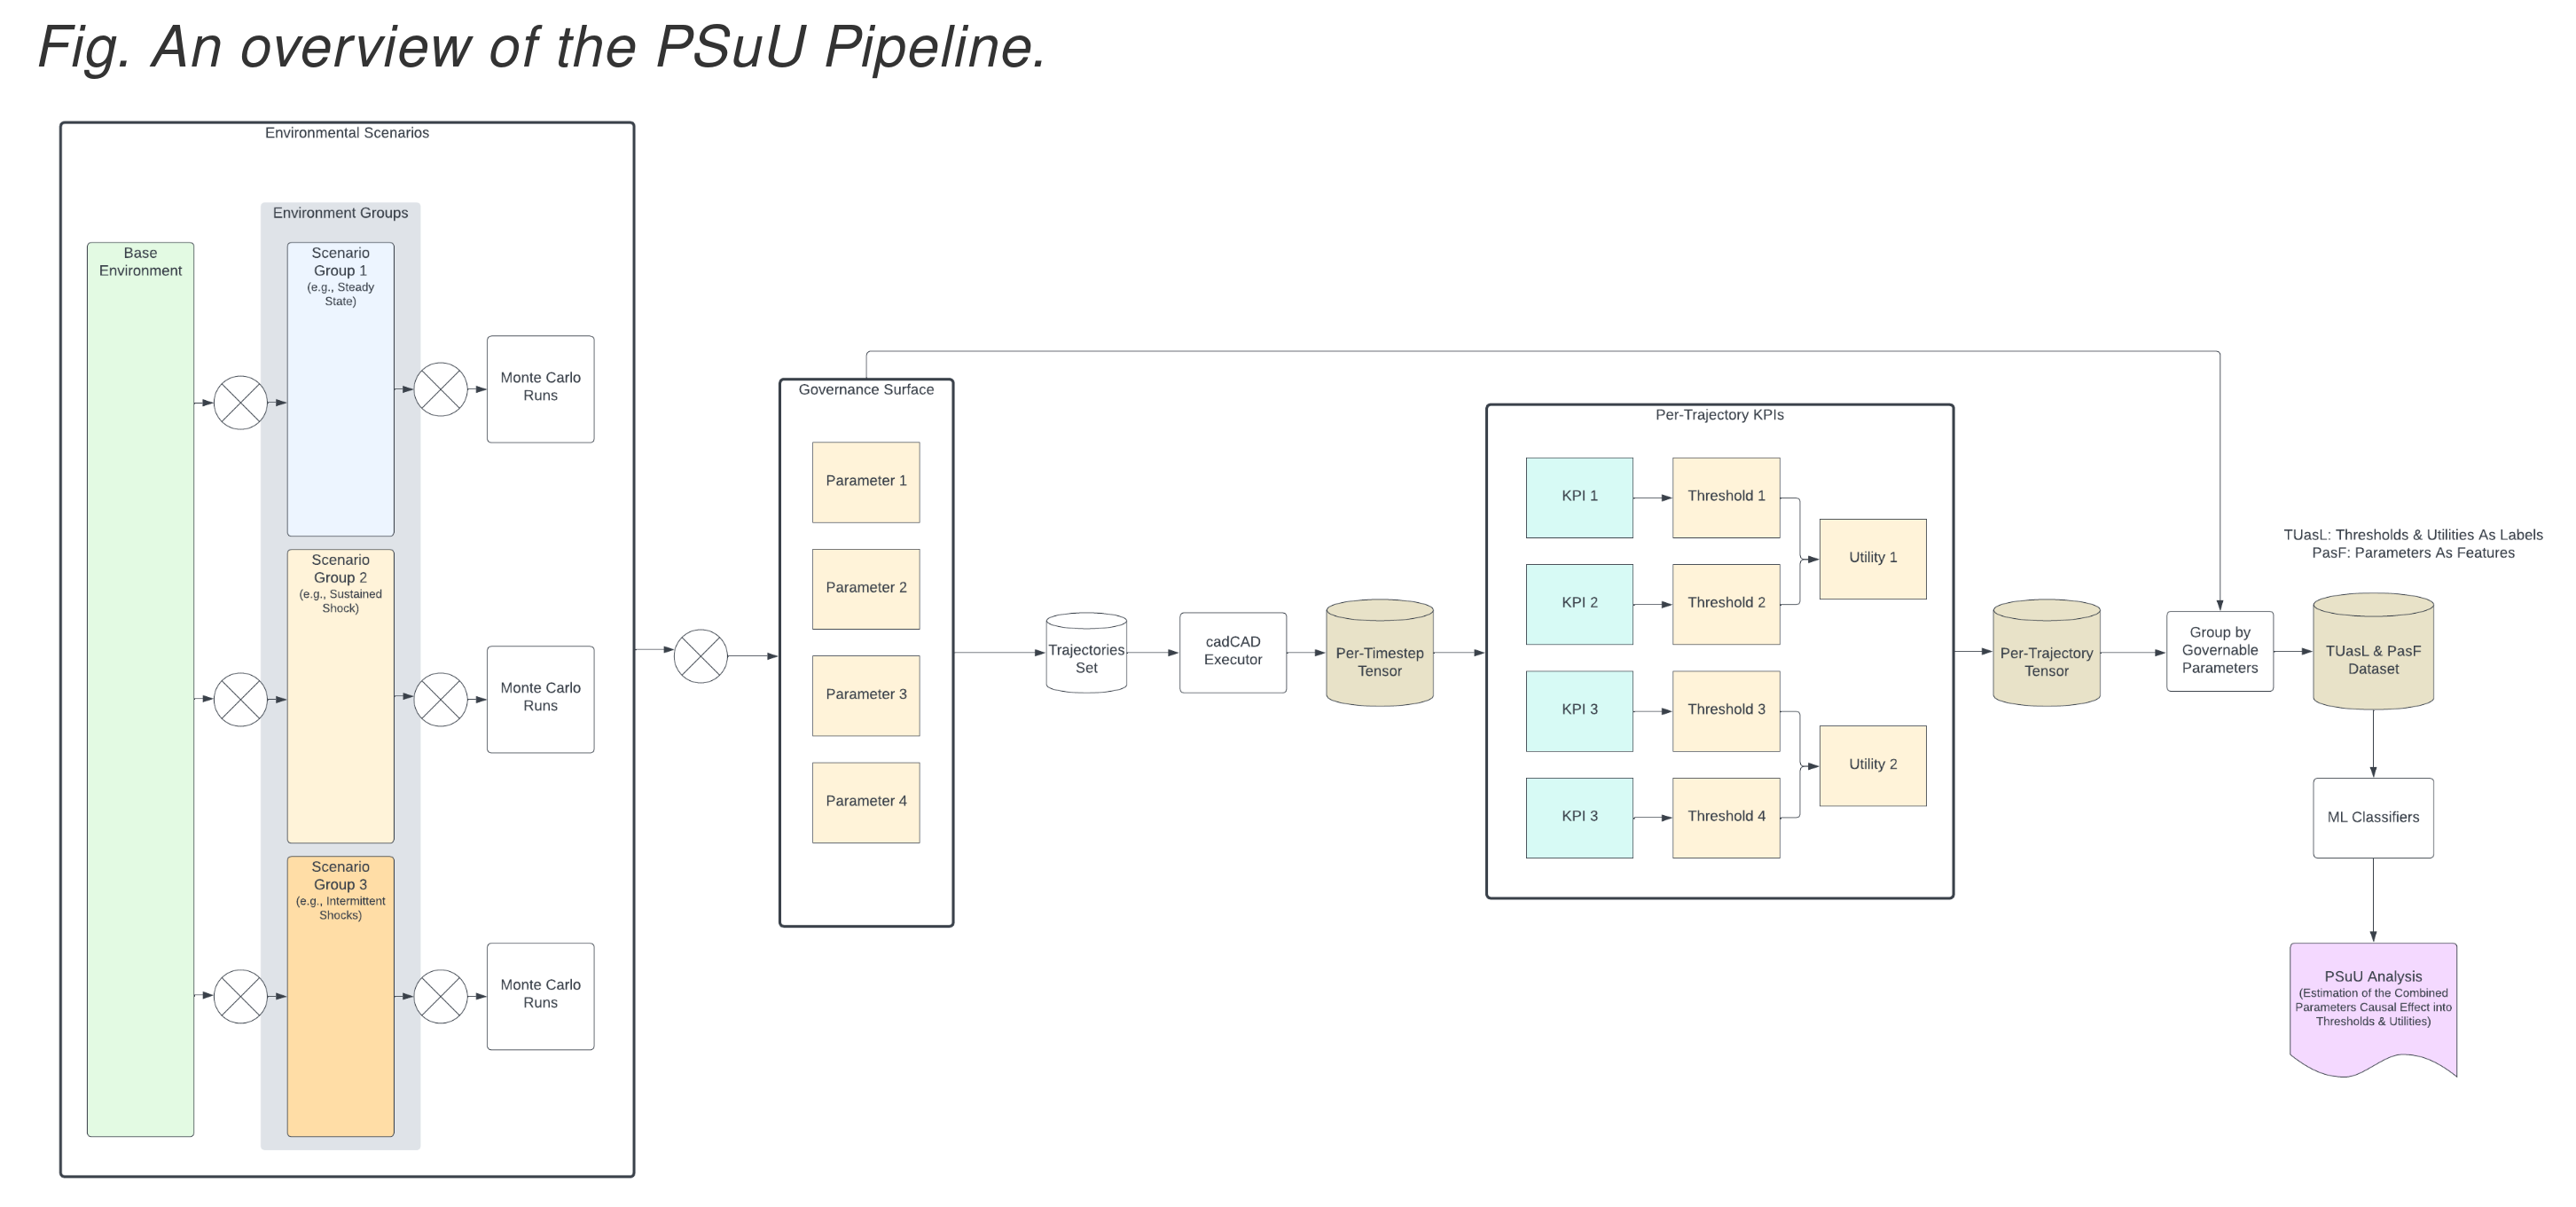

## Part 2. Loading and Cleaning the Per-Timestep Tensor

In [15]:
import sys
sys.path.append('../../')

import matplotlib.pyplot as plt
from glob import glob
import os
import pandas as pd
import hvplot.pandas
import holoviews as hv
from typing import Callable, Dict, List, Tuple, Union
from tqdm.auto import tqdm

from subspace_model.psuu.plots import create_decision_tree_importances_plot
from subspace_model.psuu import timestep_tensor_to_trajectory_tensor, GOVERNANCE_SURFACE_PARAMS
from subspace_model.psuu.kpis import KPI_functions, calculate_goal_score, GOAL_KPI_GROUPS

In [16]:
pd.set_option('display.max_columns', None)

lastest_folder = sorted(glob("../../data/simulations/psuu_run-*"))[-1]
files = [f for f in os.listdir(lastest_folder) if 'timestep_tensor' in f]

sim_df = pd.read_pickle(f"{lastest_folder}/{files[0]}", compression='gzip')

N_sweeps = len(sim_df.subset.unique())
N_runs = len(sim_df.run.unique())
N_trajectories = N_sweeps * N_runs
N_timesteps = len(sim_df.timestep.unique())
N_measurements = N_trajectories * N_timesteps

print(f"Tensor Size: {N_measurements=:,} over {N_trajectories=:,} | ({N_sweeps=:,}, {N_runs=:,}, {N_timesteps=:,})\t")

Tensor Size: N_measurements=438,800 over N_trajectories=400 | (N_sweeps=20, N_runs=20, N_timesteps=1,097)	


In [17]:
glob("../../data/")

['../../data/']

In [18]:
sim_df.days_passed.max()

1096.0

Aggregating trajectories.

In [19]:
traj_tensors = []
for file in tqdm(files):
    filepath = f"{lastest_folder}/{file}"
    _df = pd.read_pickle(filepath, compression='gzip')
    traj_tensors.append(timestep_tensor_to_trajectory_tensor(_df))

agg_df = pd.concat(traj_tensors).reset_index()

agg_df.set_index(GOVERNANCE_SURFACE_PARAMS+['subset', 'run']).describe()

  0%|          | 0/3 [00:00<?, ?it/s]

simulation  mean_relative_community_owned_supply  \
count        50.0                             50.000000   
mean          0.0                              0.249620   
std           0.0                              0.027967   
min           0.0                              0.204225   
25%           0.0                              0.231911   
50%           0.0                              0.249595   
75%           0.0                              0.264057   
max           0.0                              0.308991   

       mean_farmer_subsidy_factor  \
count                   50.000000   
mean                     0.998996   
std                      0.000960   
min                      0.994501   
25%                      0.998765   
50%                      0.999293   
75%                      0.999614   
max                      0.999821   

       mean_proposing_rewards_per_newly_pledged_space  \
count                                    5.000000e+01   
mean                                     6.725222e-13   
std                                      3.434994e-13   
min                                      1.534422e-13   
25%                                      4.365646e-13   
50%                                      6.141890e-13   
75%                                      9.112798e-13   
max                                      1.377724e-12   

       mean_proposer_reward_minus_voter_reward  cumm_rewards_before_1yr  \
count                                50.000000             5.000000e+01   
mean                              92461.415419             7.369603e+07   
std                               47225.859054             3.497665e+07   
min                               21095.934327             2.100960e+07   
25%                               60020.893186             5.256000e+07   
50%                               84441.494907             7.889760e+07   
75%                              125286.891386             8.409600e+07   
max                              189415.788474             1.471680e+08   

       abs_sum_storage_fees_per_sum_compute_fees  cumm_rewards  
count                                  50.000000  5.000000e+01  
mean                                41312.945489  1.844185e+08  
std                                 26736.118833  9.419412e+07  
min                                 12885.038552  4.207680e+07  
25%                                 22708.122047  1.197144e+08  
50%                                 26894.454827  1.684224e+08  
75%                                 47309.066035  2.498904e+08  
max                                 96234.601653  3.777984e+08

Kernal density estimate plots of KPI outcomes over trajectories.

Evaluating the utility tensor.

In [20]:


# Type alias for a Criterion function
Criterion = Callable[[float, pd.Series], bool]

def evaluate(x: pd.Series, data: pd.DataFrame, success_criteria: Union[str, Criterion]) -> pd.Series:
    col_name = x.name  # Assuming col_name comes from the Series name
    if isinstance(success_criteria, str):
        if success_criteria == 'smaller_than_median':
            y = data.loc[:, col_name] < data.loc[:, col_name].median()
        elif success_criteria == 'larger_than_median':
            y = data.loc[:, col_name] > data.loc[:, col_name].median()
        else:
            raise Exception('Criteria not specified')
    else:
        y = data[col_name].map(lambda z: success_criteria(z, data[col_name]))
    return y

utility_dfs: List[pd.DataFrame] = []
for kpi, (kpi_f, threshold_f) in KPI_functions.items():
    kpi_df = agg_df[[kpi]]
    utility_df = kpi_df.apply(lambda x: evaluate(x, agg_df, threshold_f))
    utility_df.name = kpi
    utility_dfs.append(utility_df)

utility_df: pd.DataFrame = pd.concat(utility_dfs, axis=1).astype(int)
utility_df.index = agg_df.set_index(GOVERNANCE_SURFACE_PARAMS+['simulation', 'subset', 'run']).index

In [21]:
utility_df.reset_index(drop=True)
utility_df.groupby('subset').mean().hvplot.heatmap(rot=25, height=800, width=1000, fontscale=1, cmap='RdYlGn', title='Utility outcomes by Parameter Subset', ylabel='Parameter Subset', xlabel='KPI Utility')

:HeatMap   [columns,index]   (value)

### Parameter Effect into System Goals

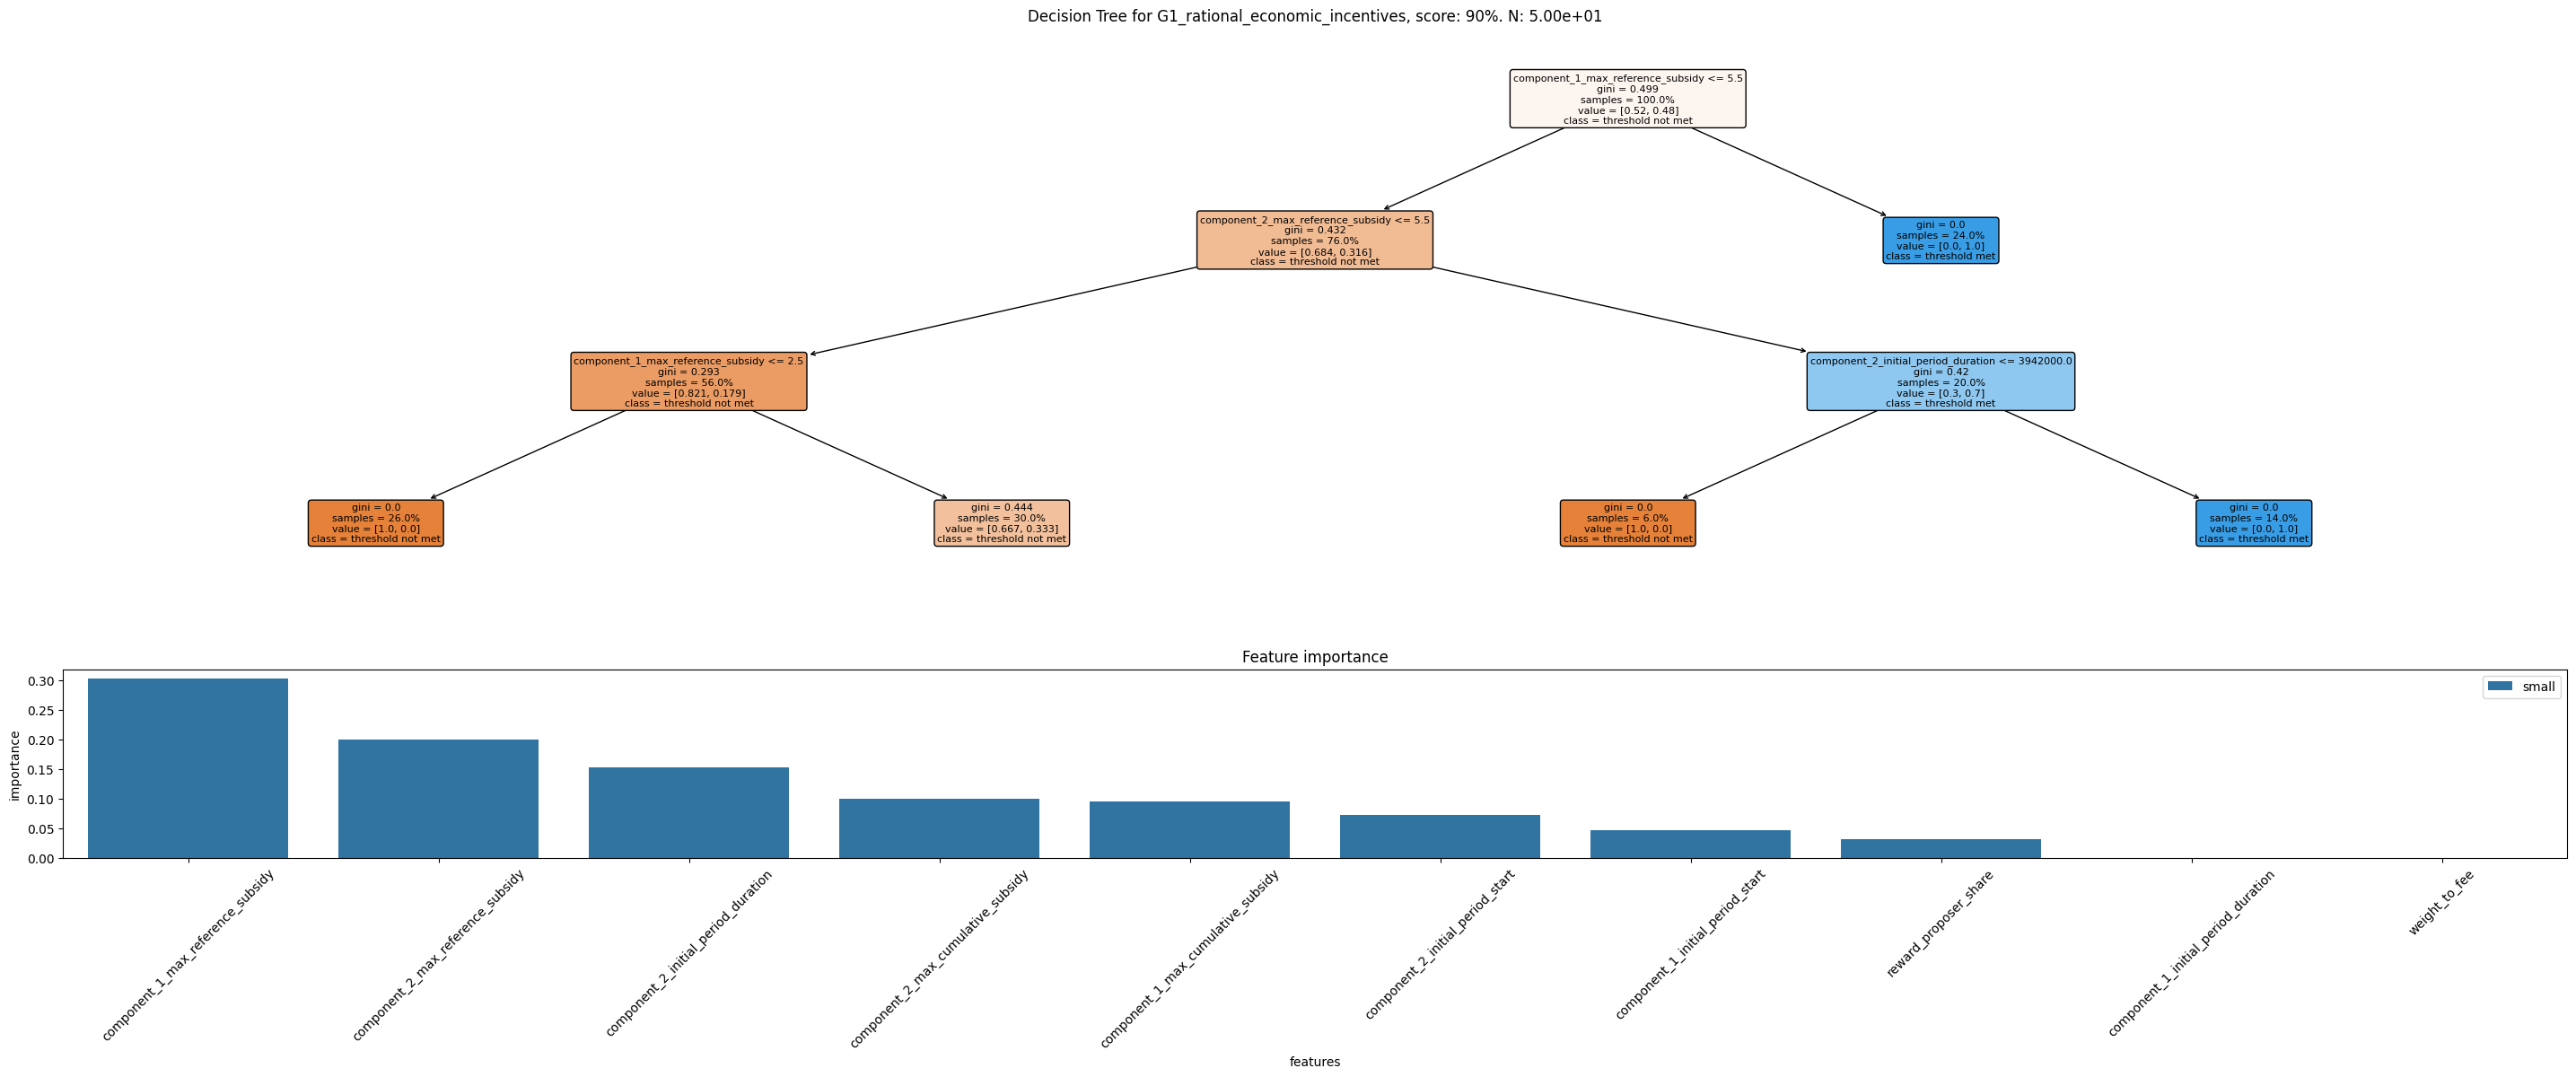

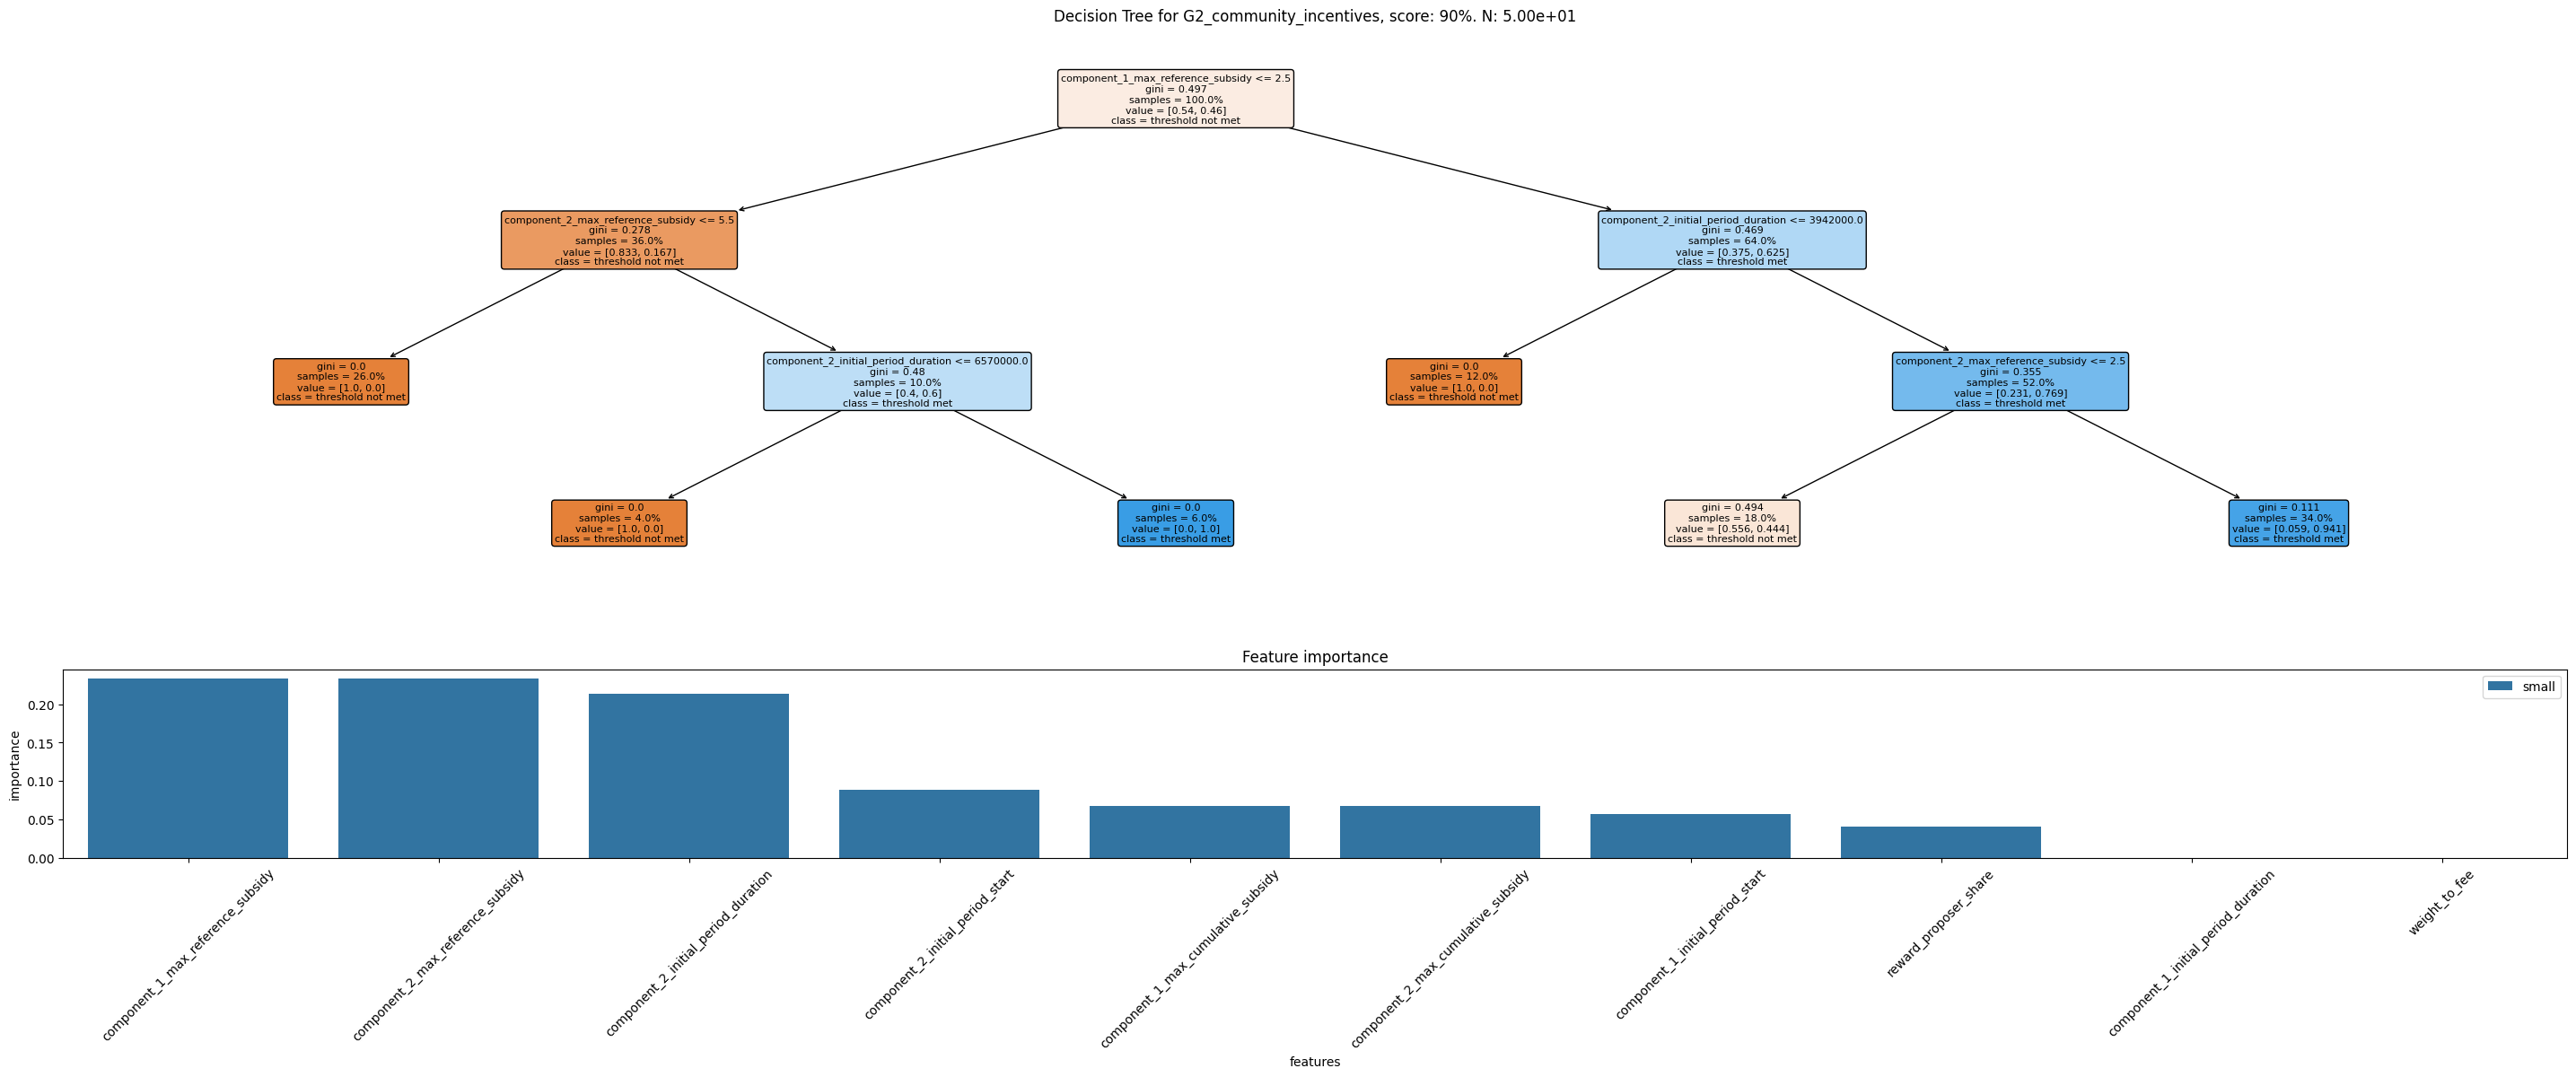

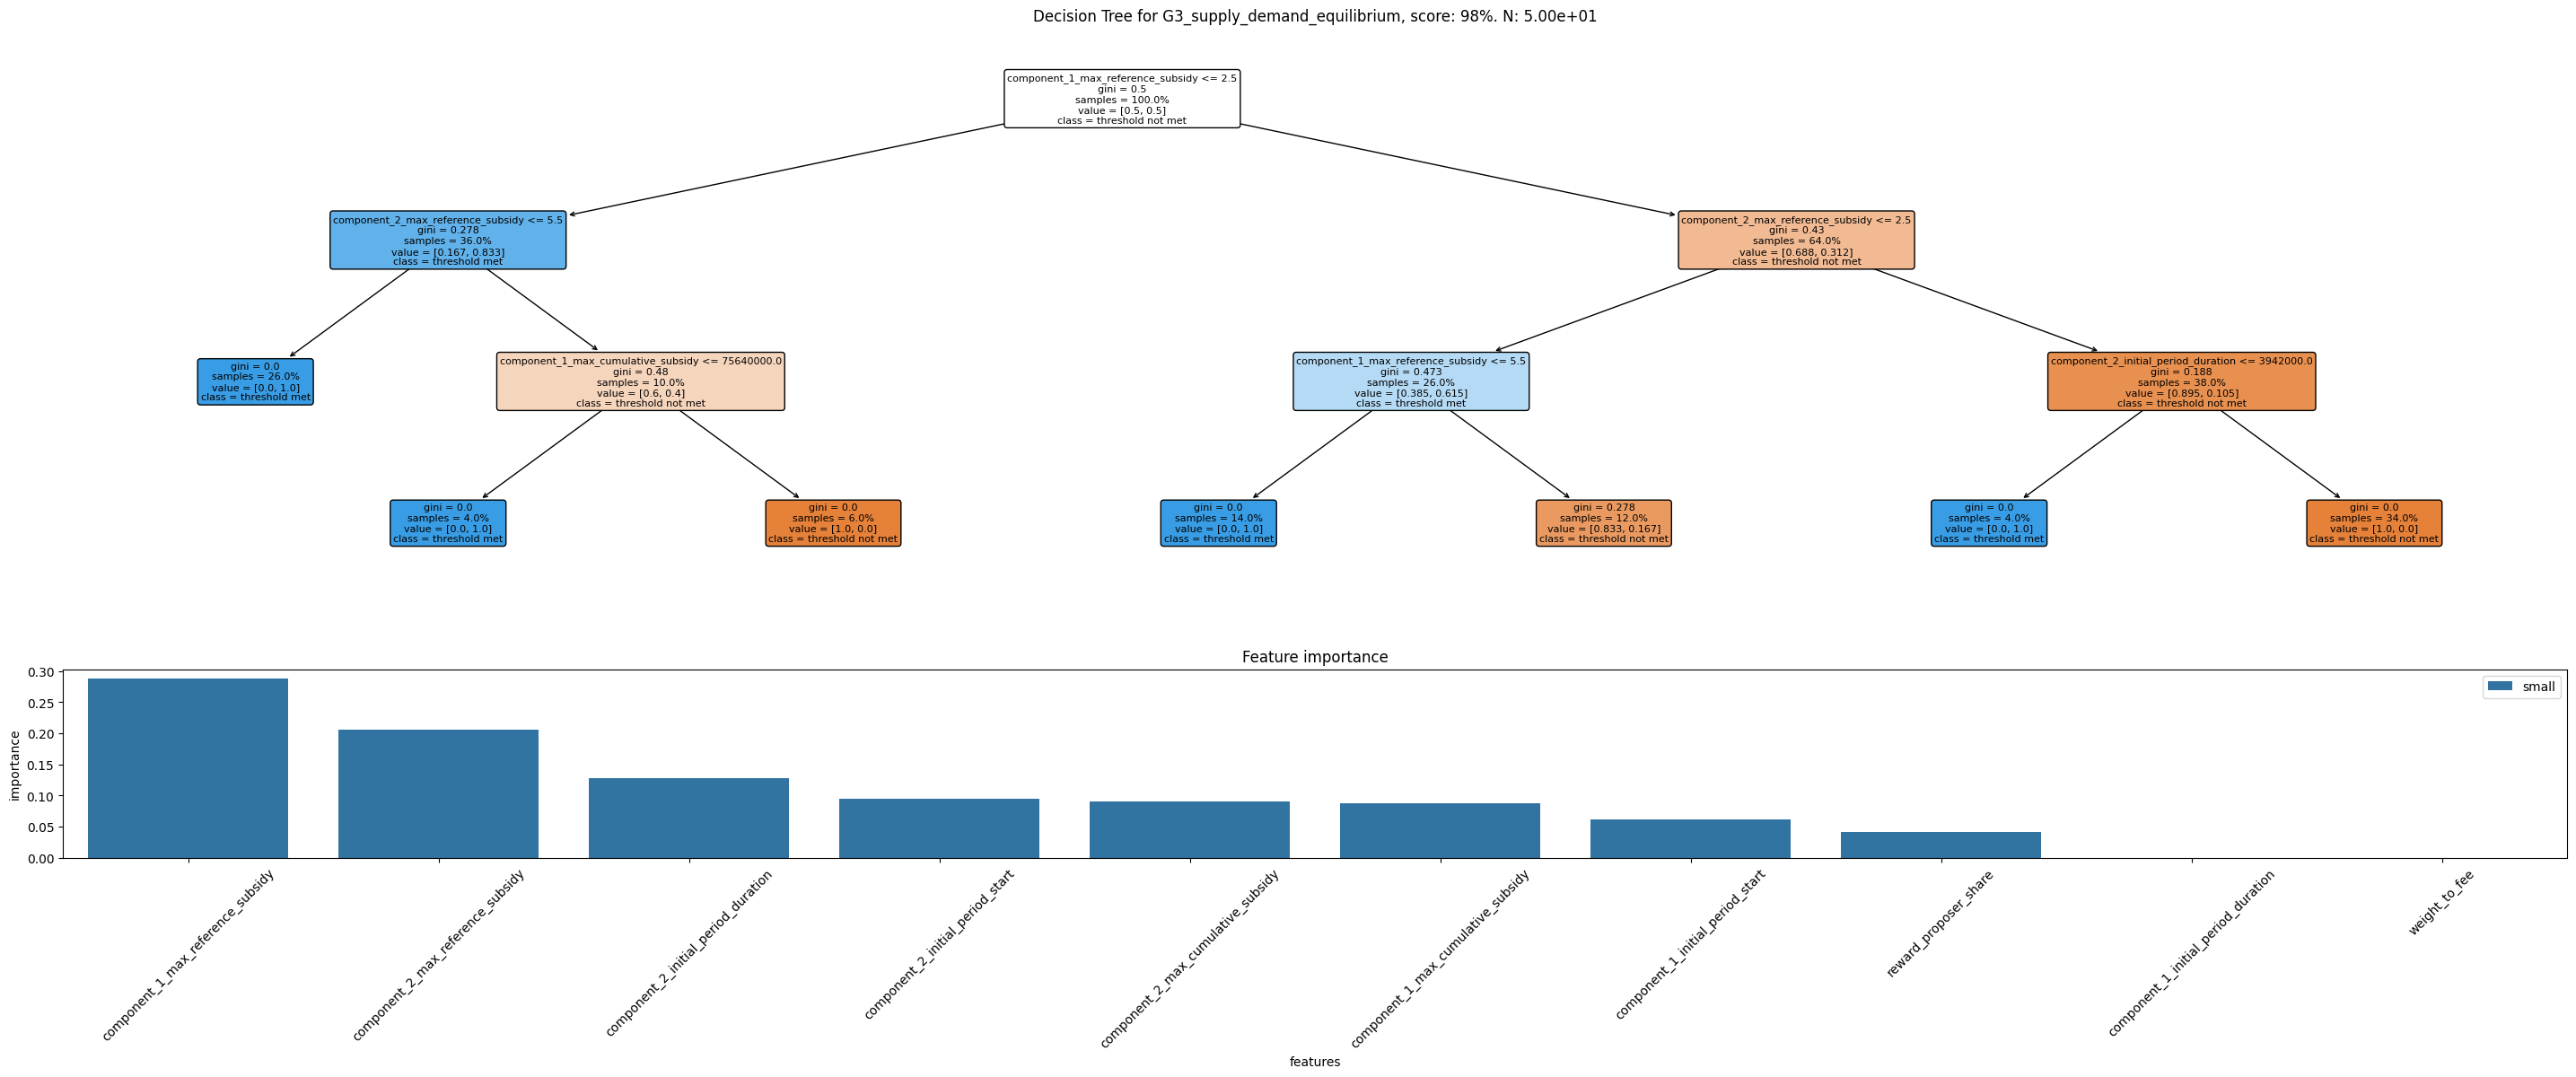

In [22]:
for goal, kpis in GOAL_KPI_GROUPS.items():
    goal_df = calculate_goal_score(agg_df, goal, goal)
    create_decision_tree_importances_plot(goal_df, goal, success_criteria='larger_than_median')


### Parameter Effect into KPIs

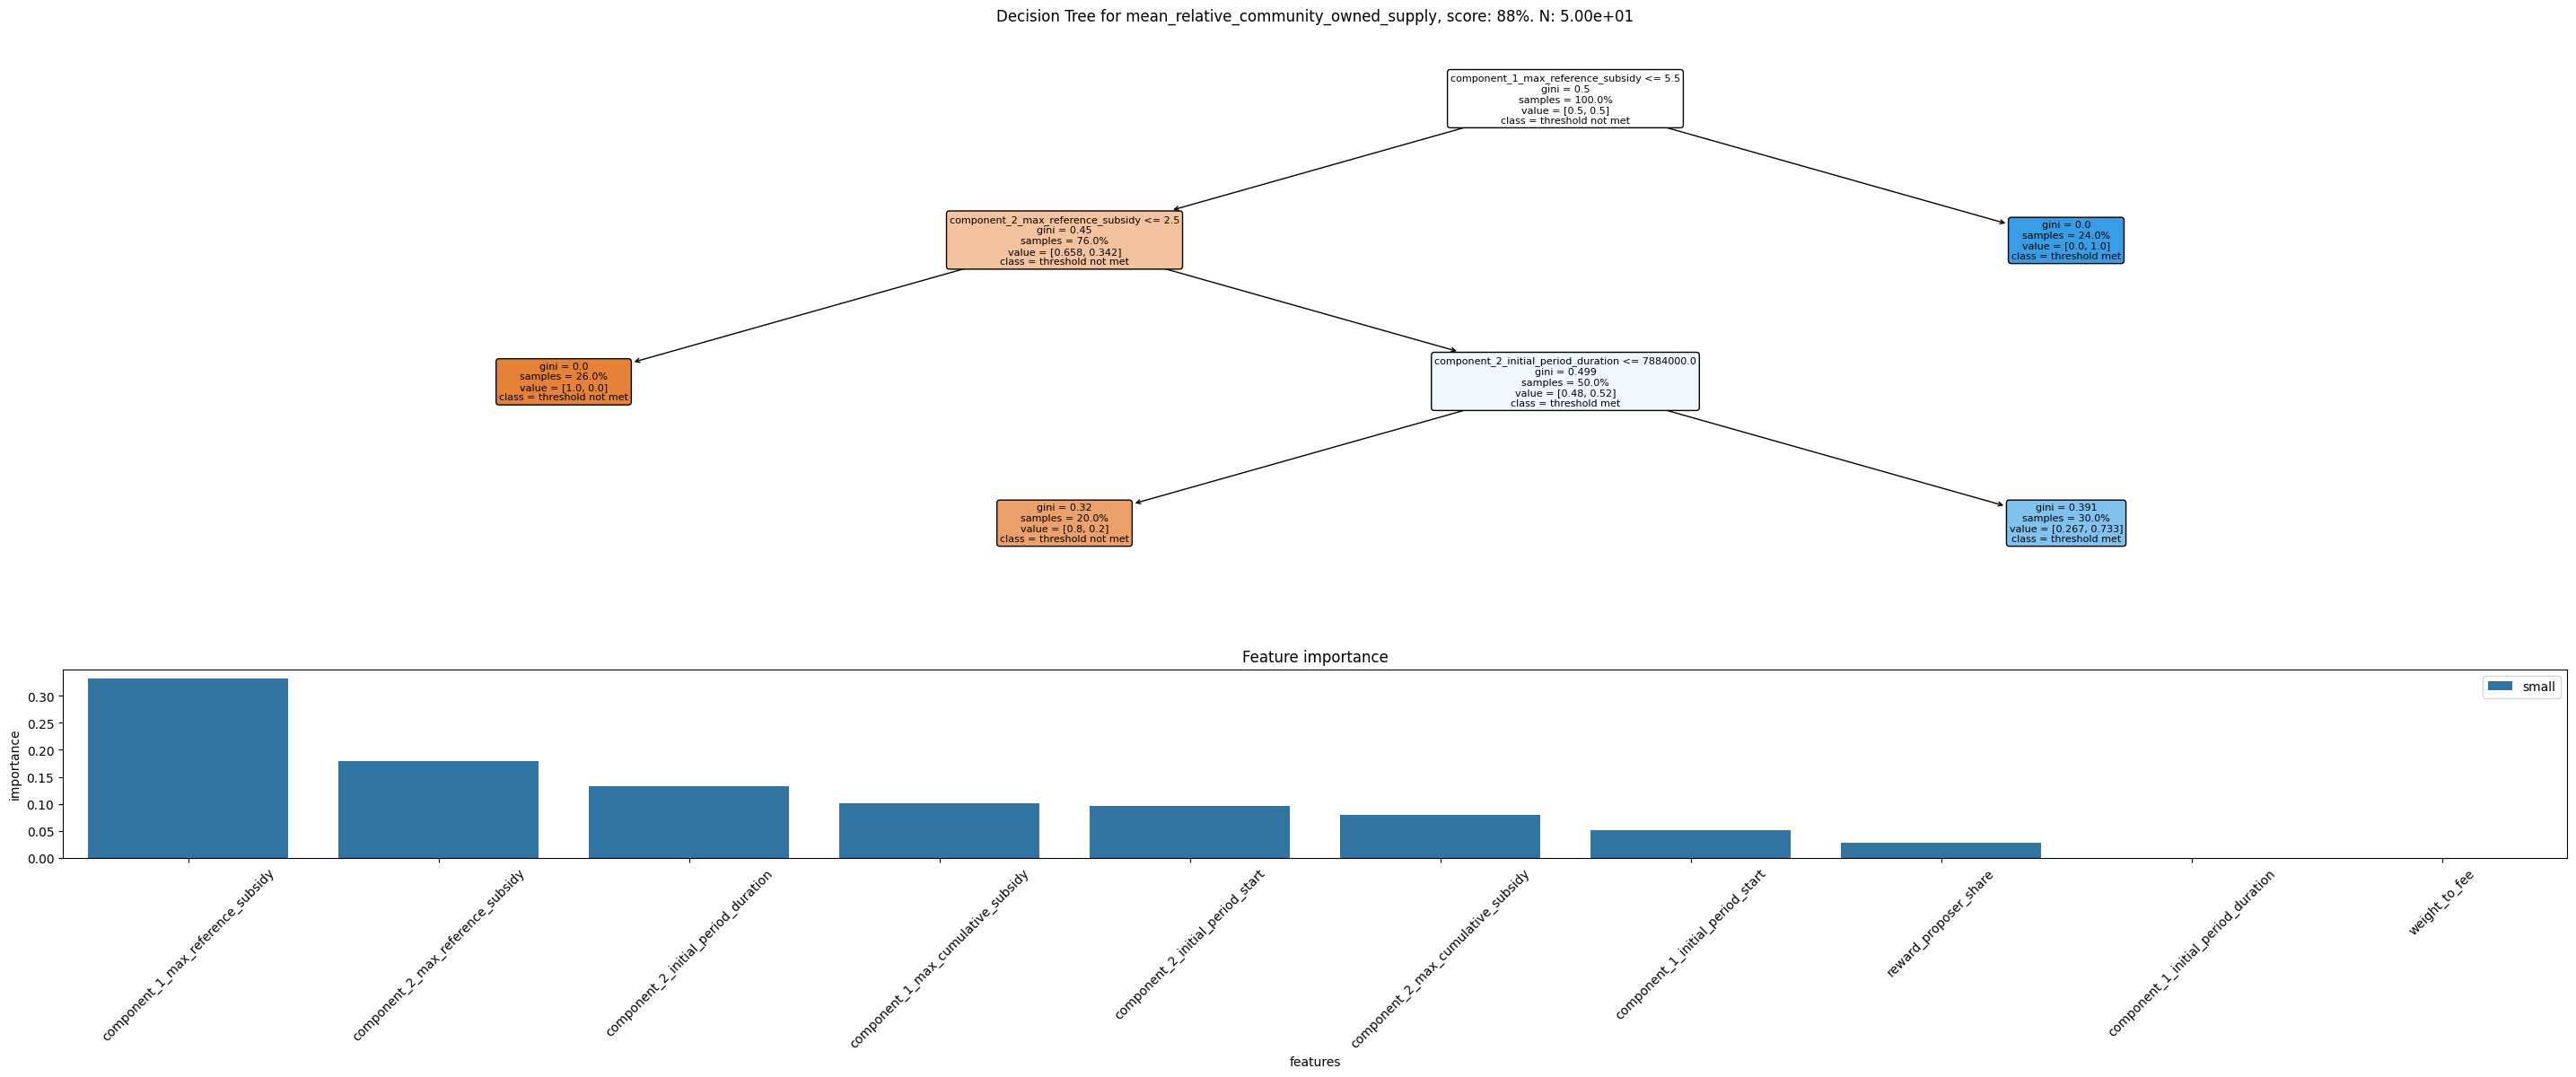

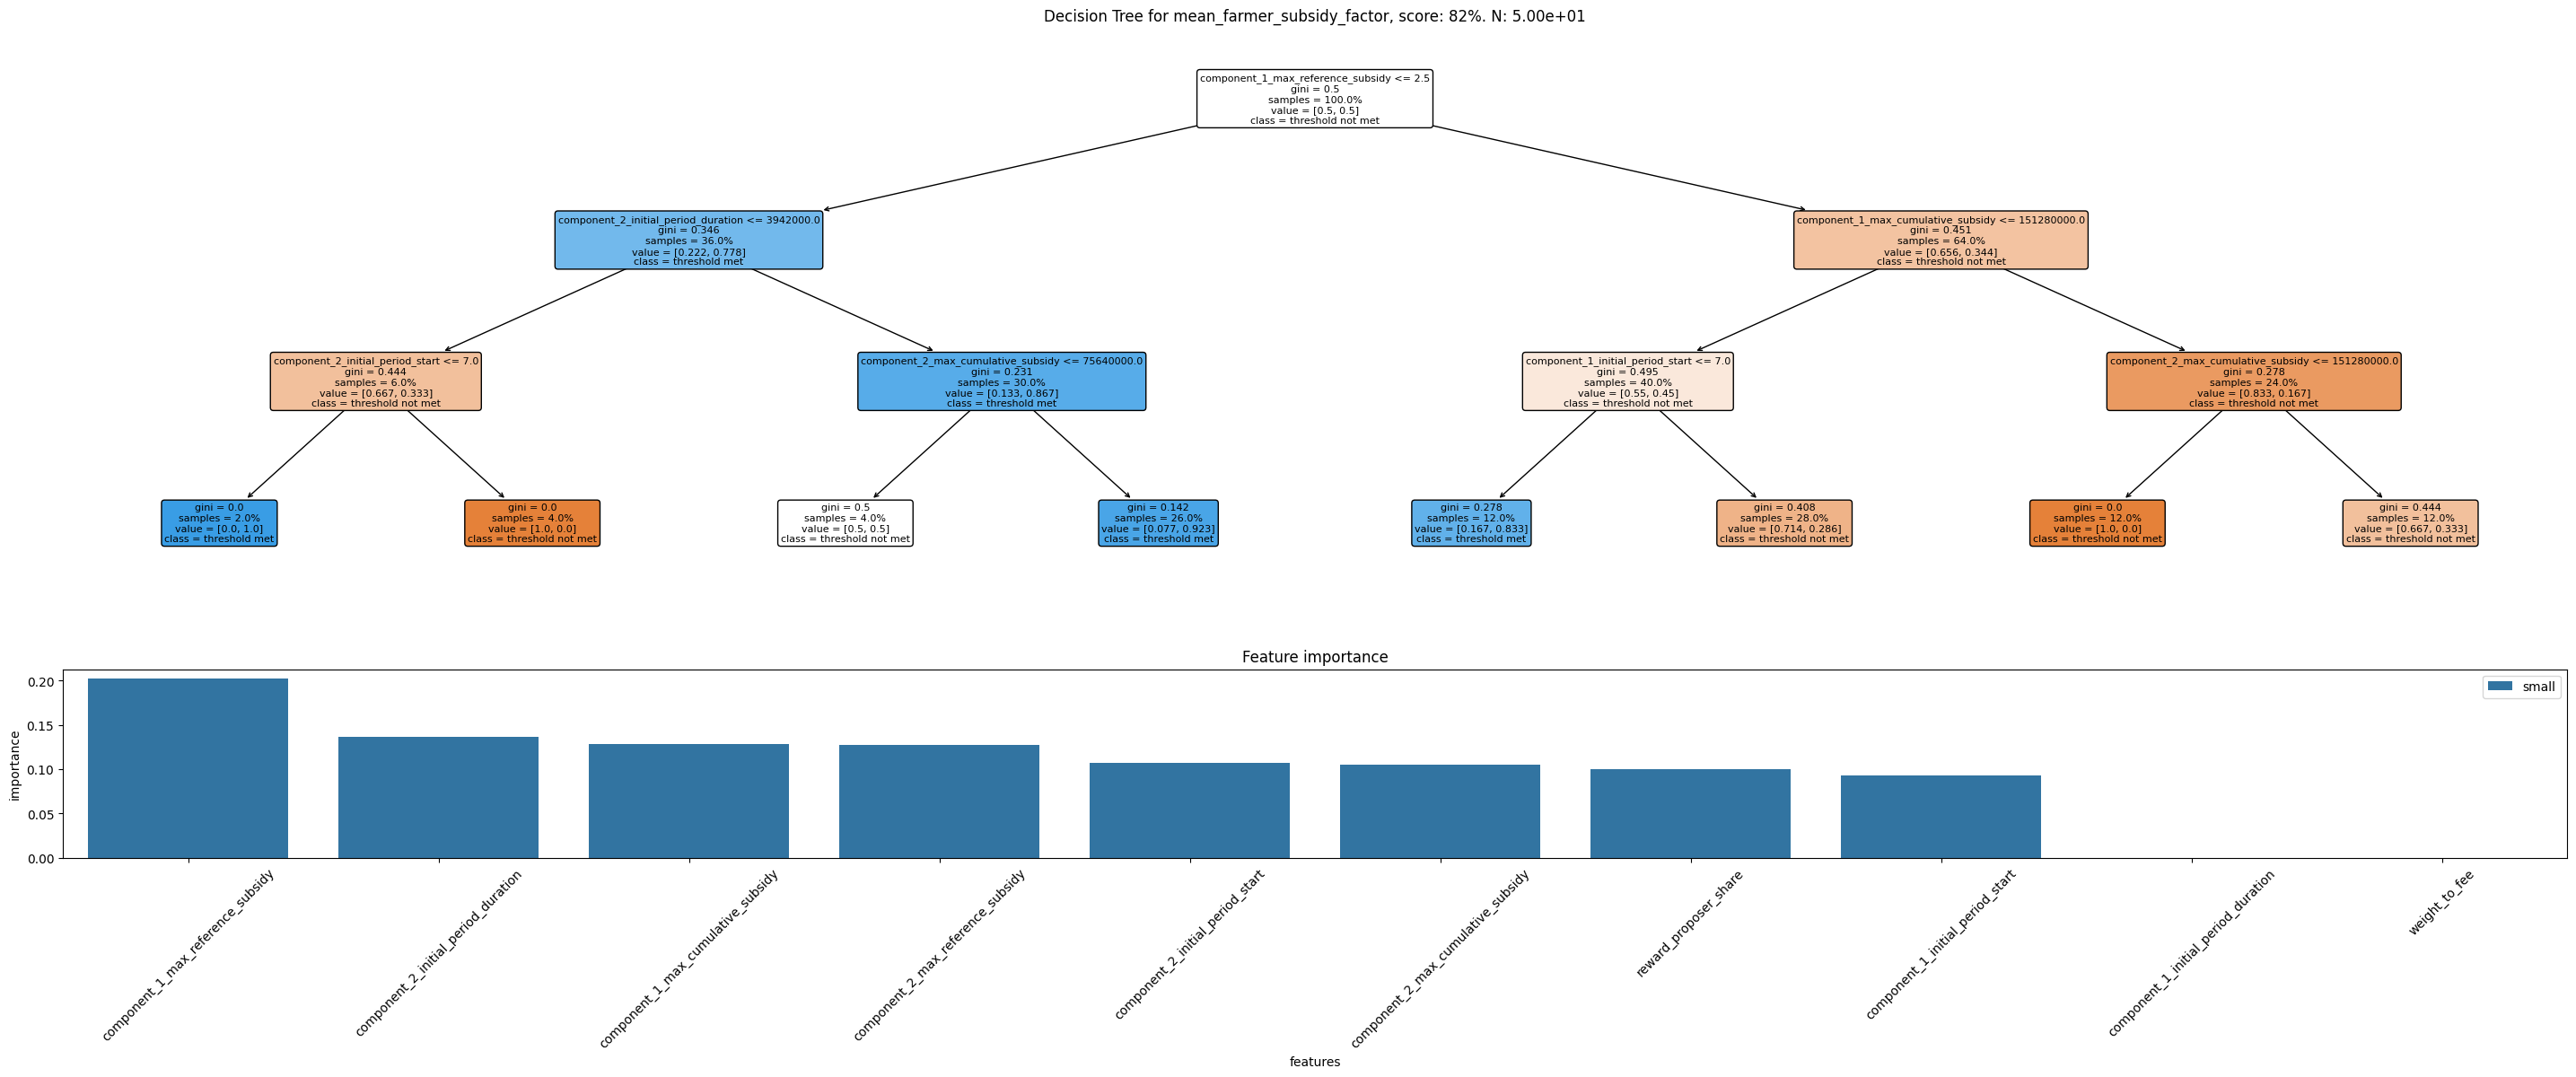

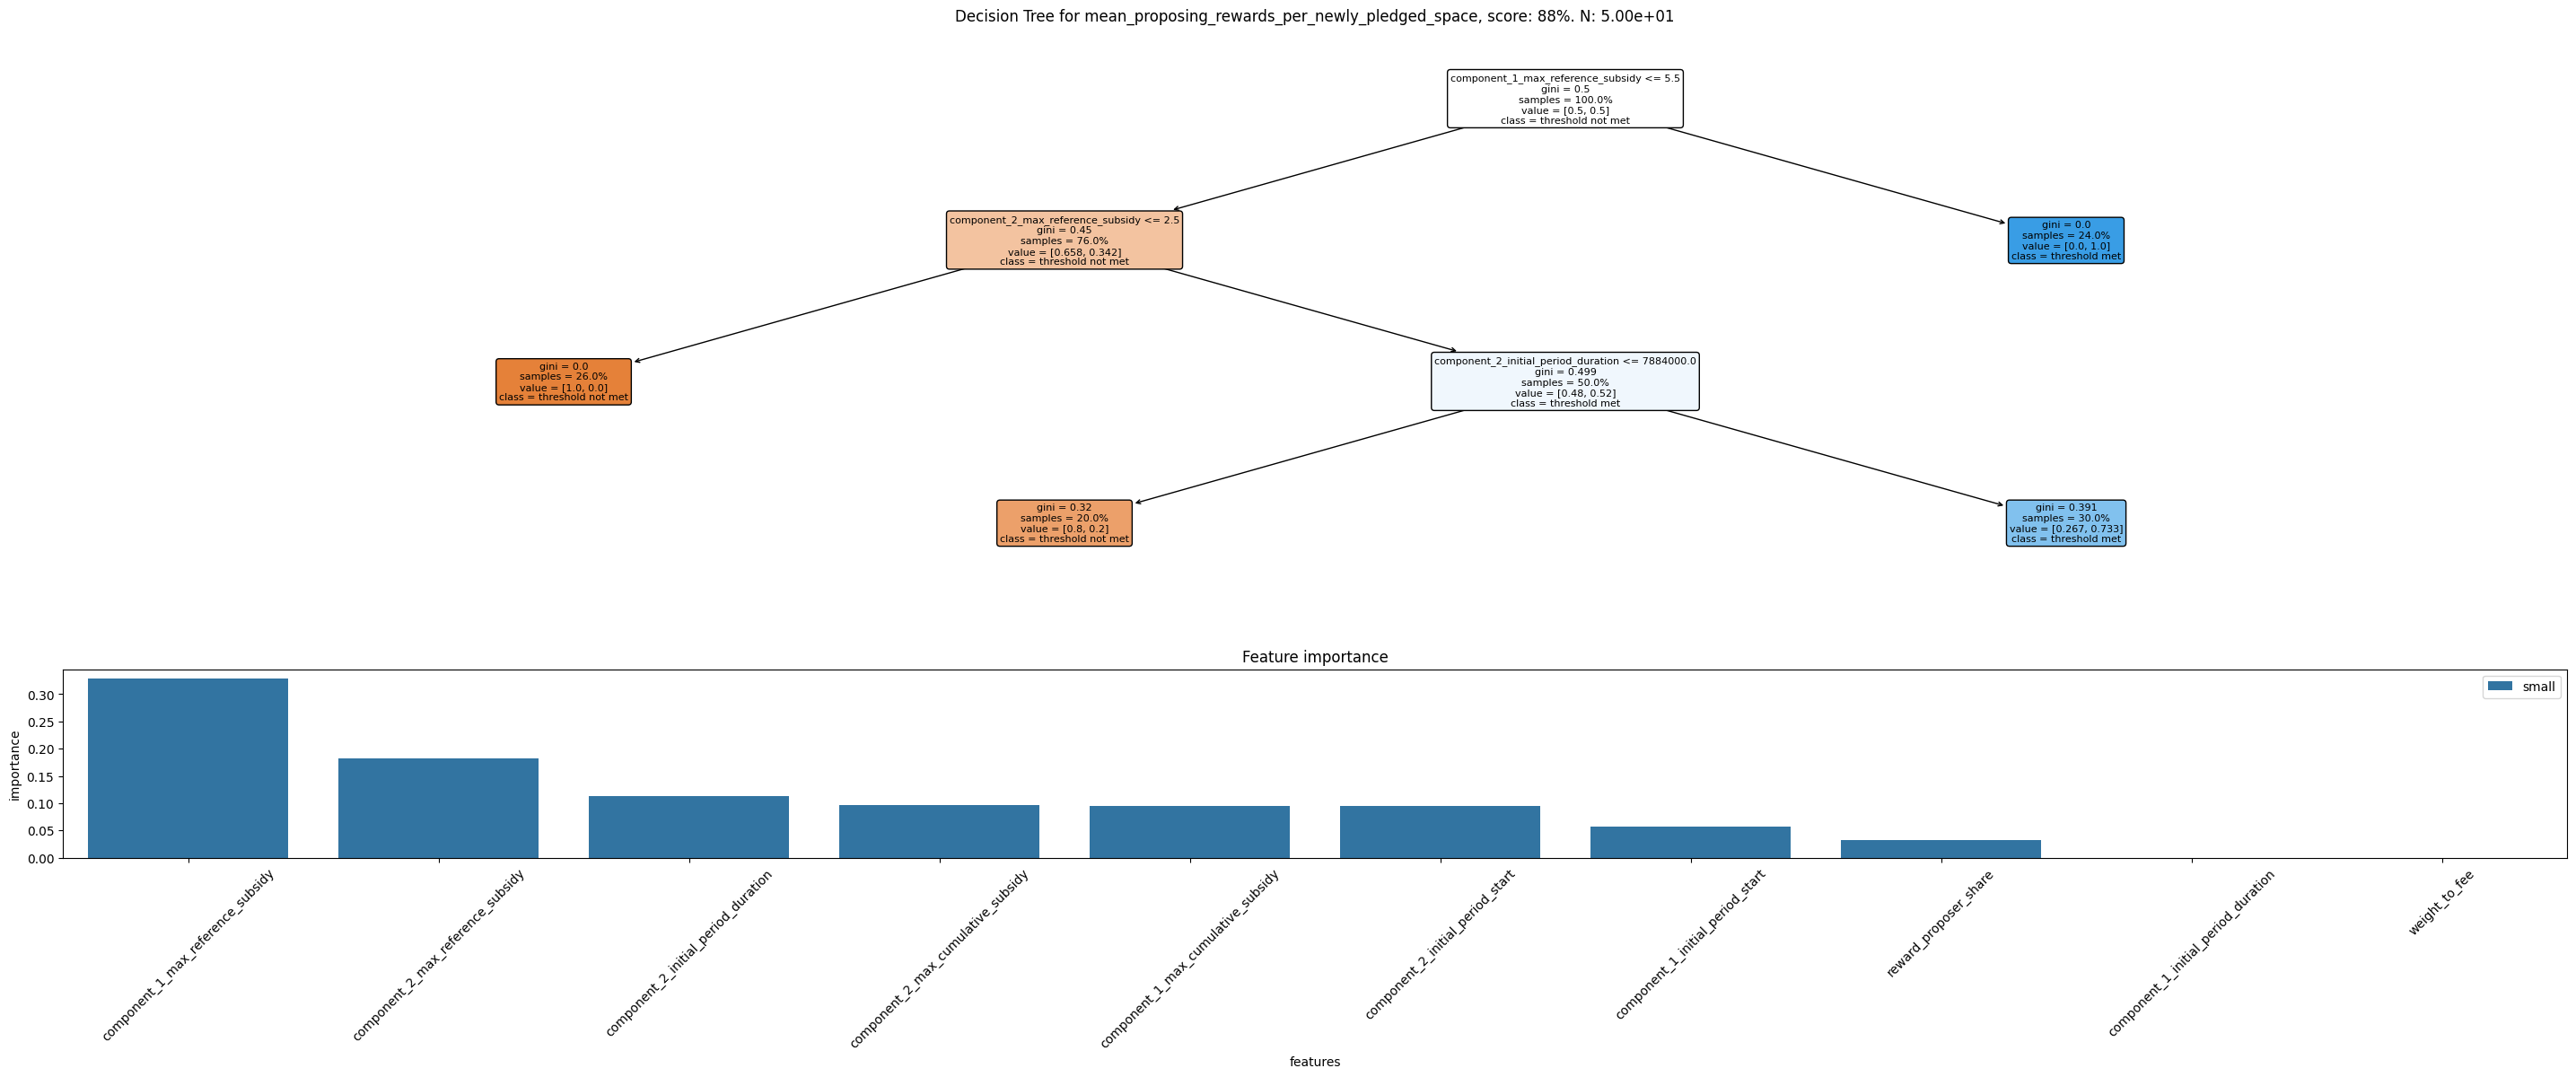

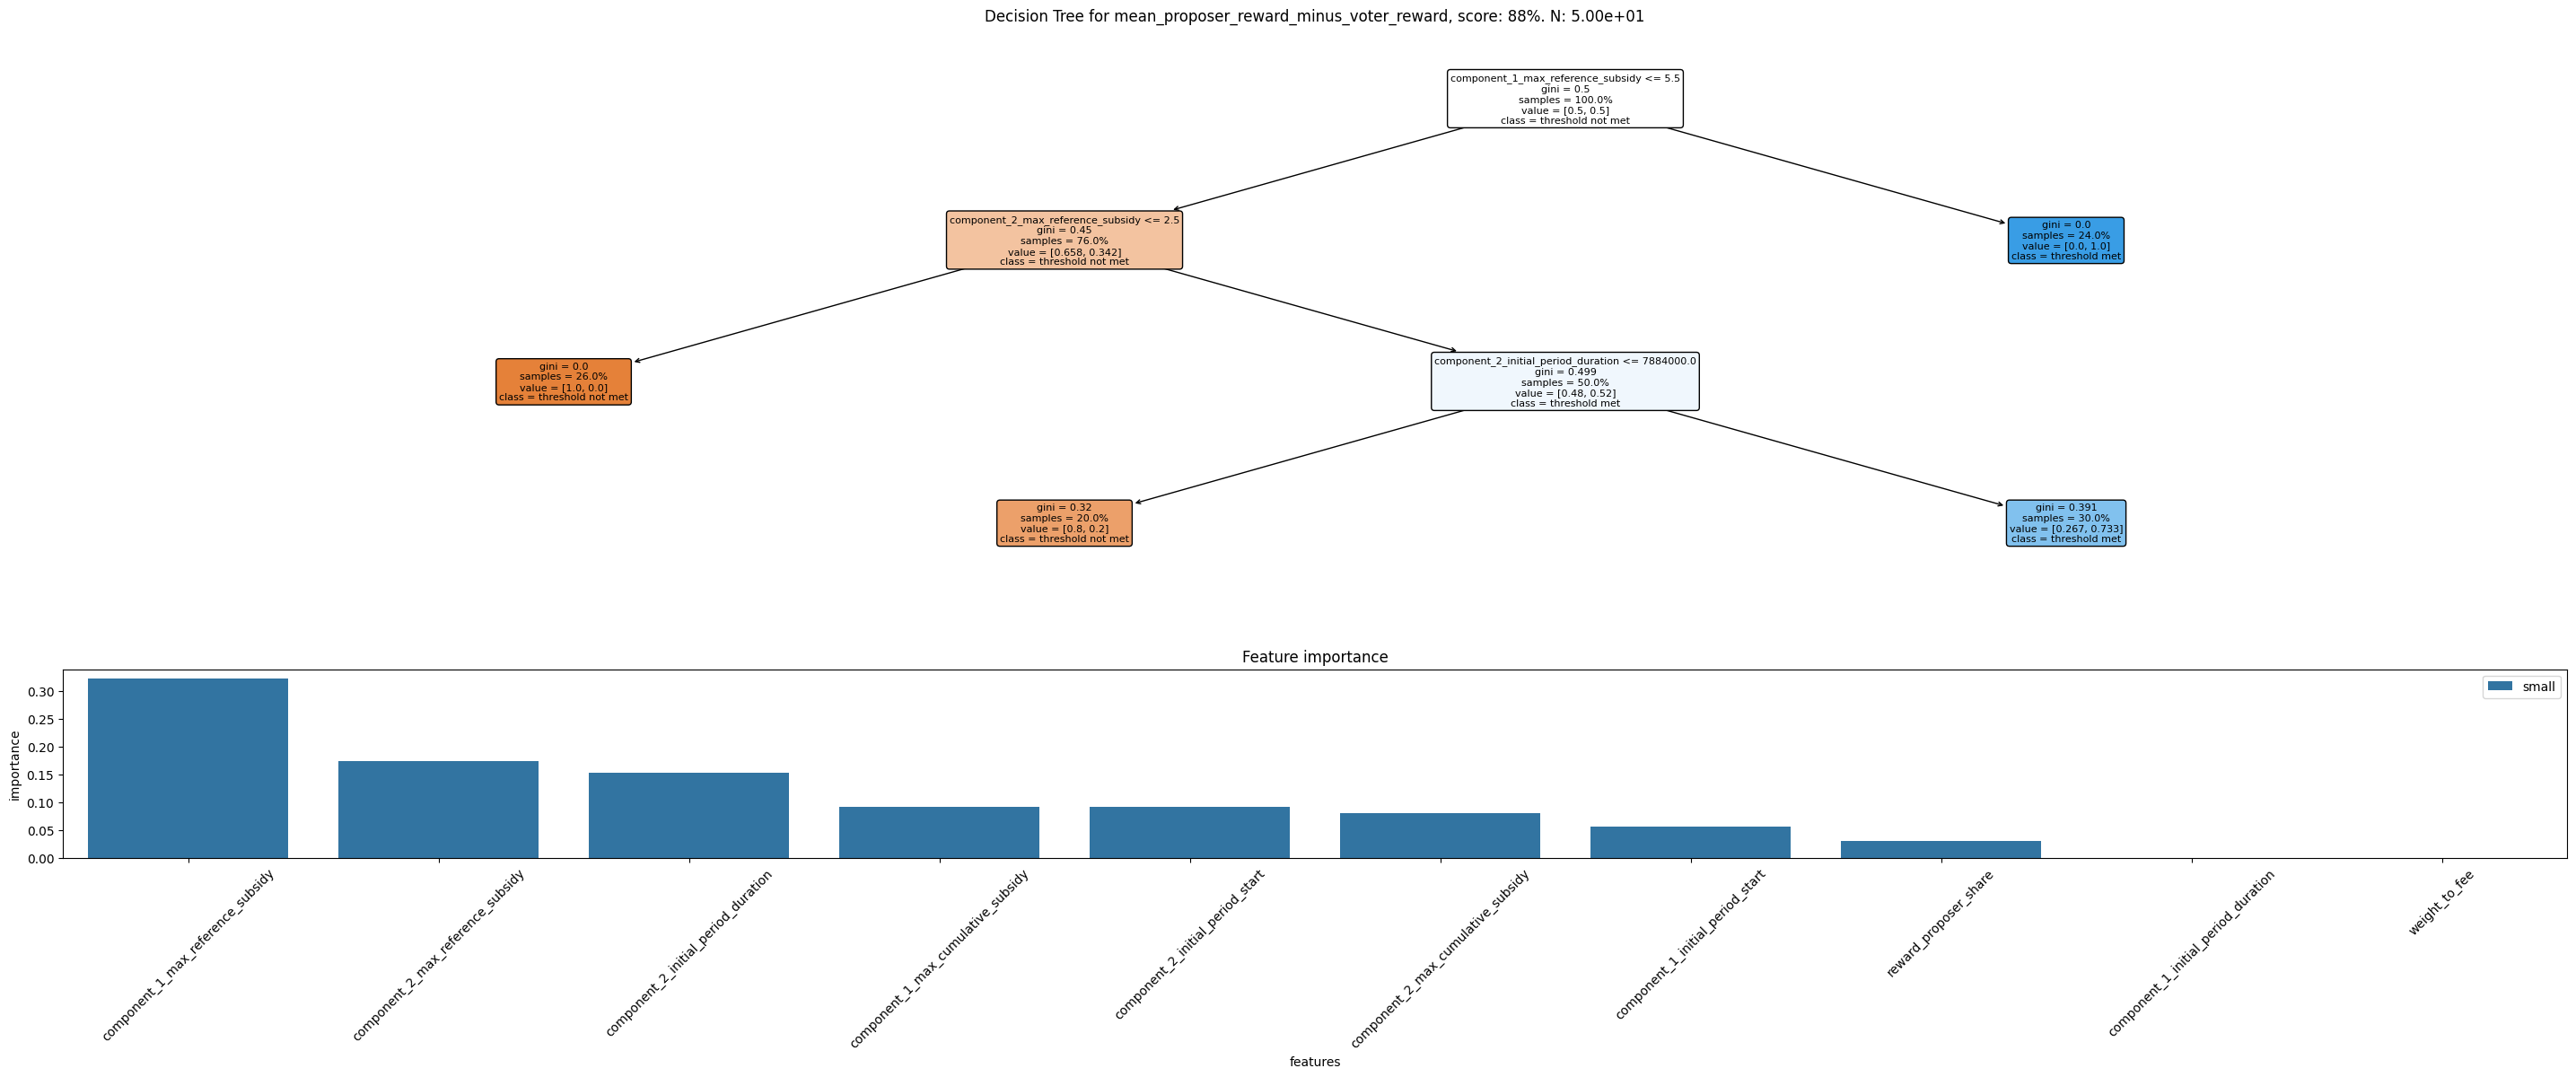

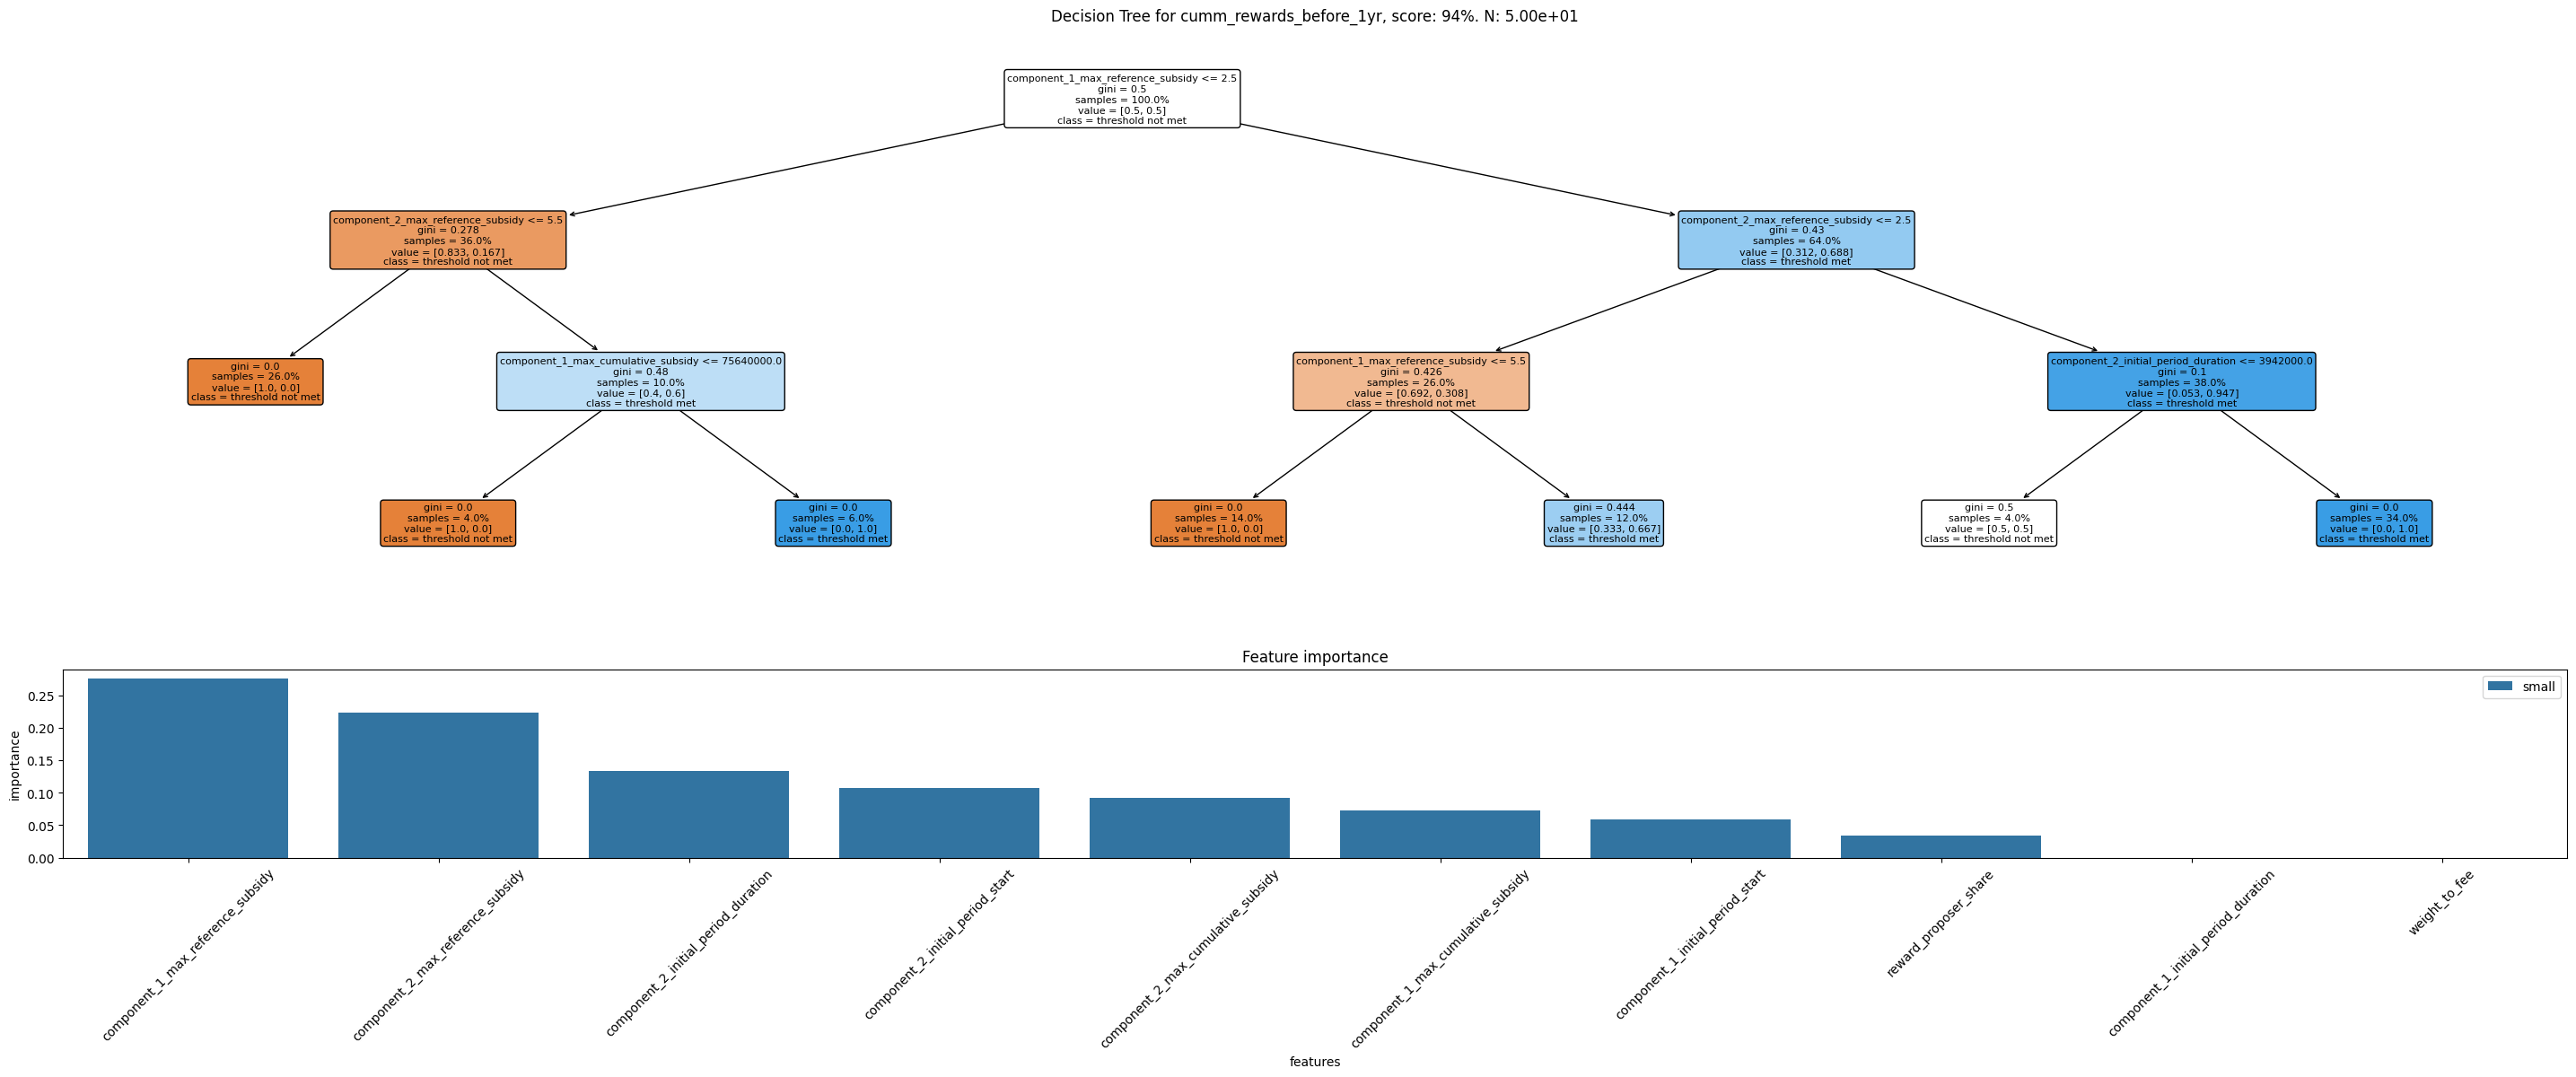

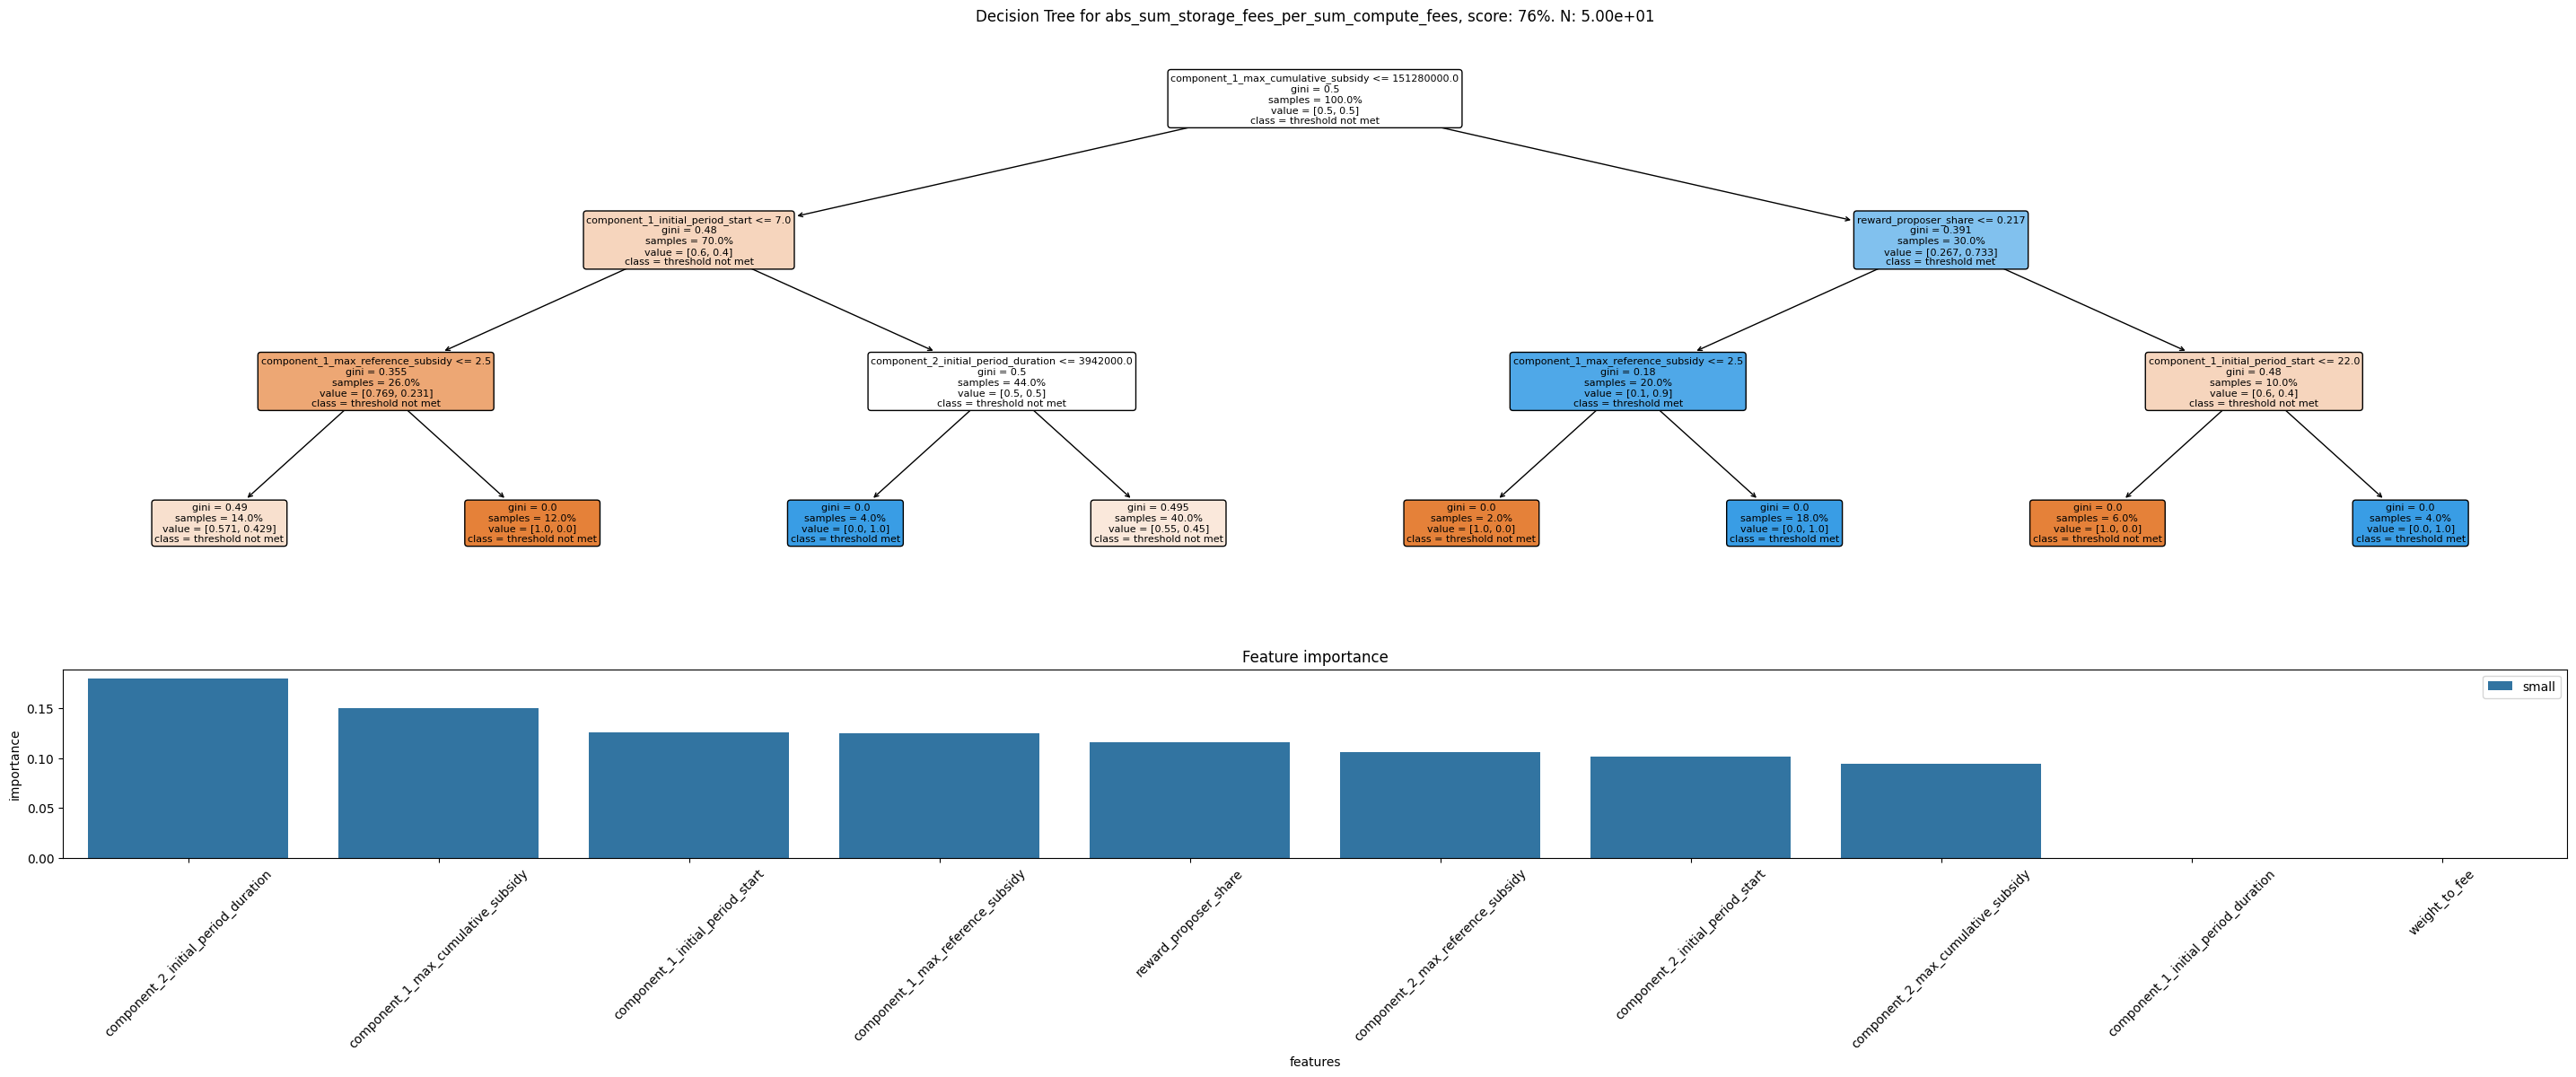

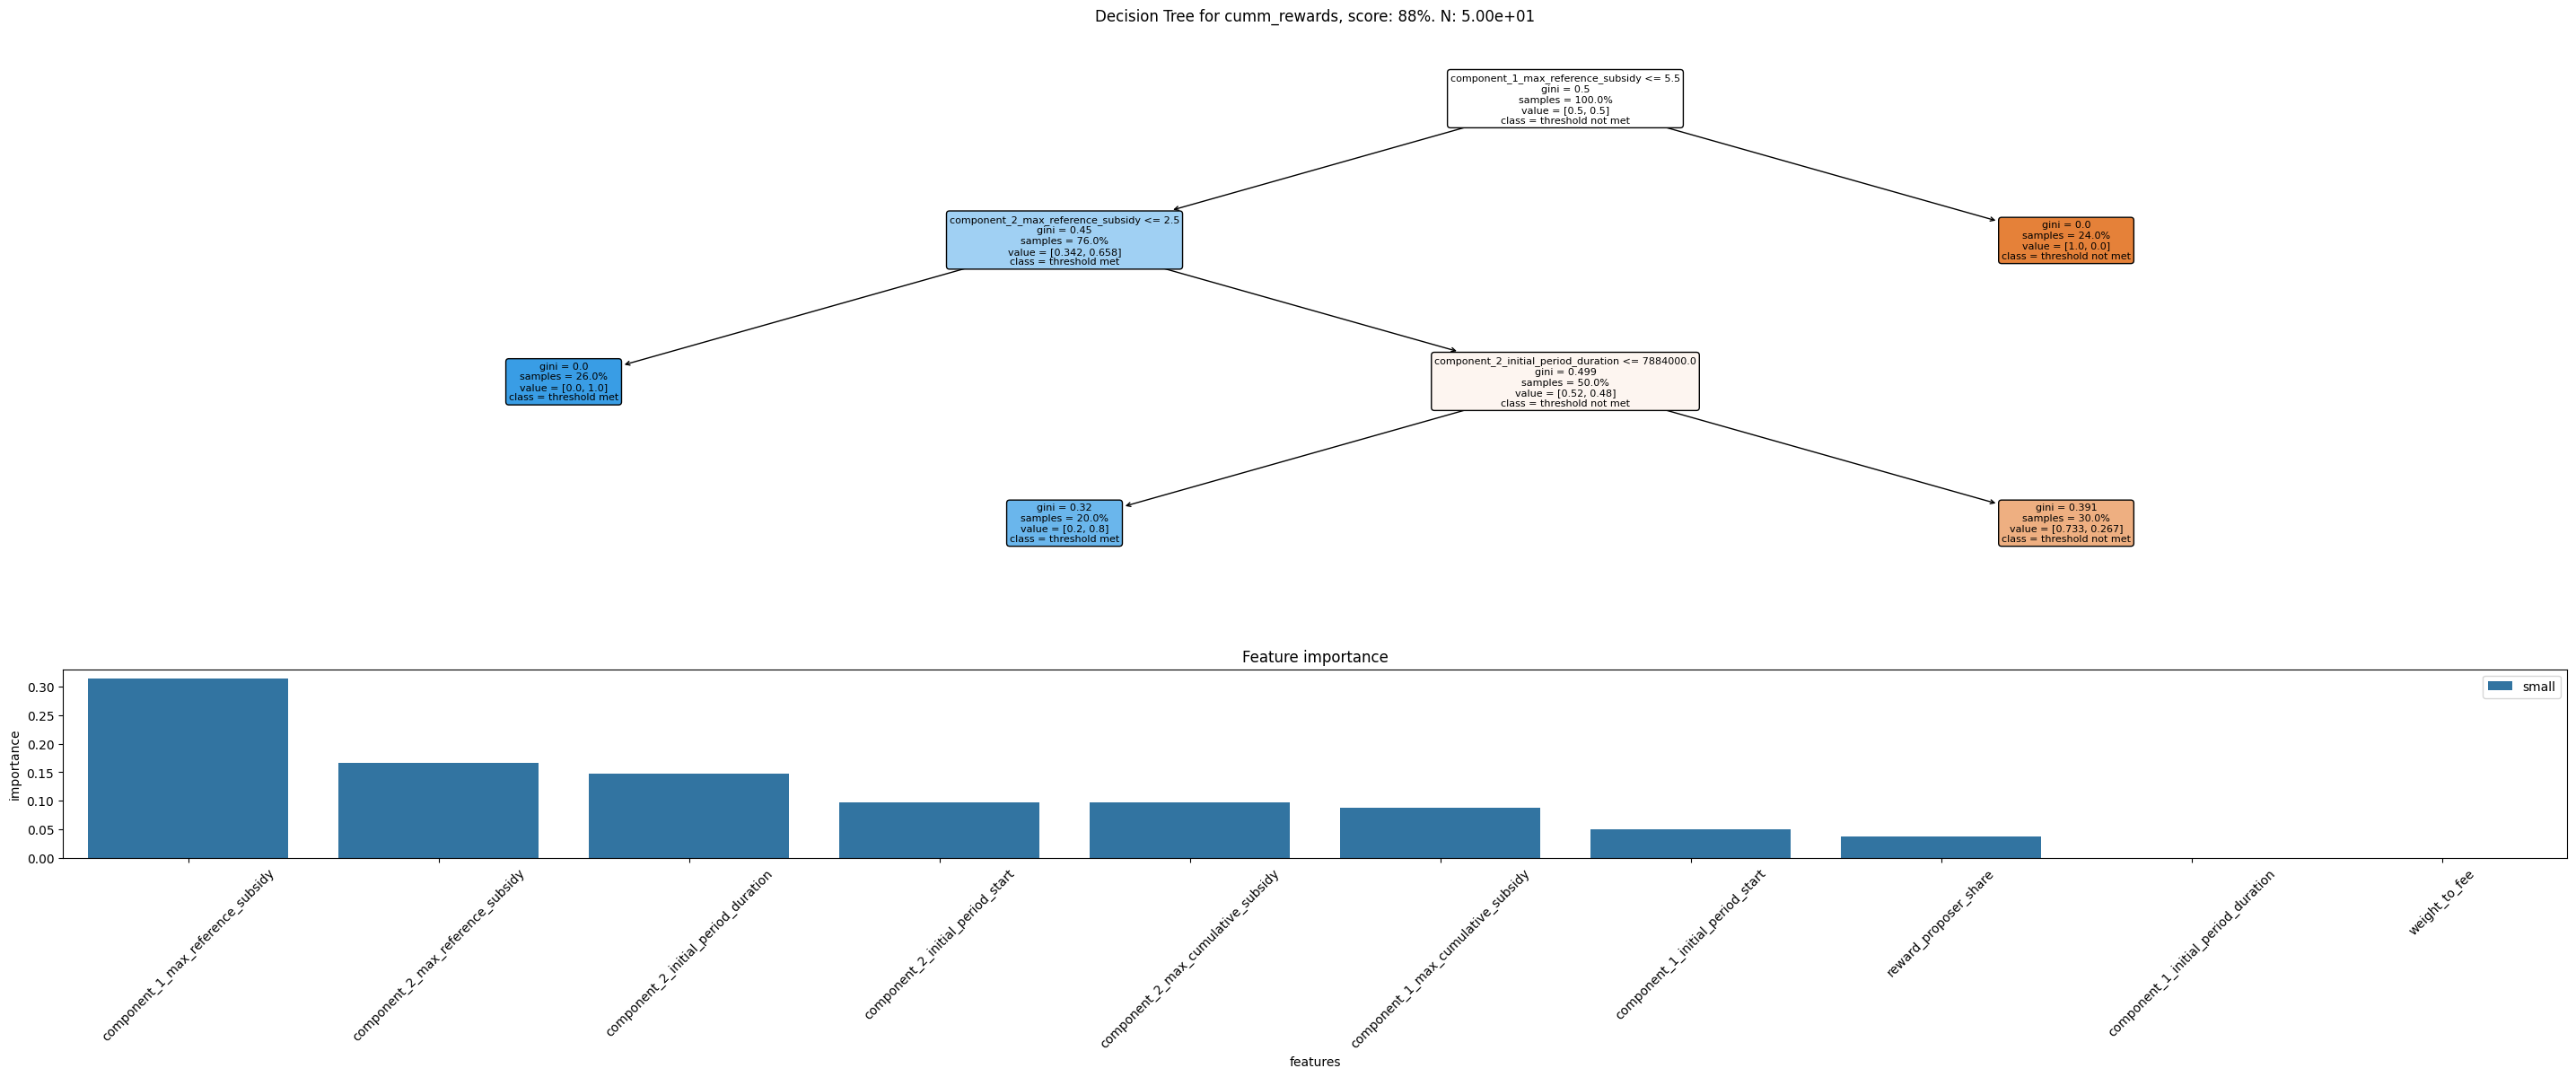

In [23]:
for col_name, (kpi_f, kpi_t) in KPI_functions.items():
    create_decision_tree_importances_plot(agg_df,
                                        col_name =col_name,
                                        success_criteria=kpi_t)
    plt.show()

### Auxiliary Visualizations

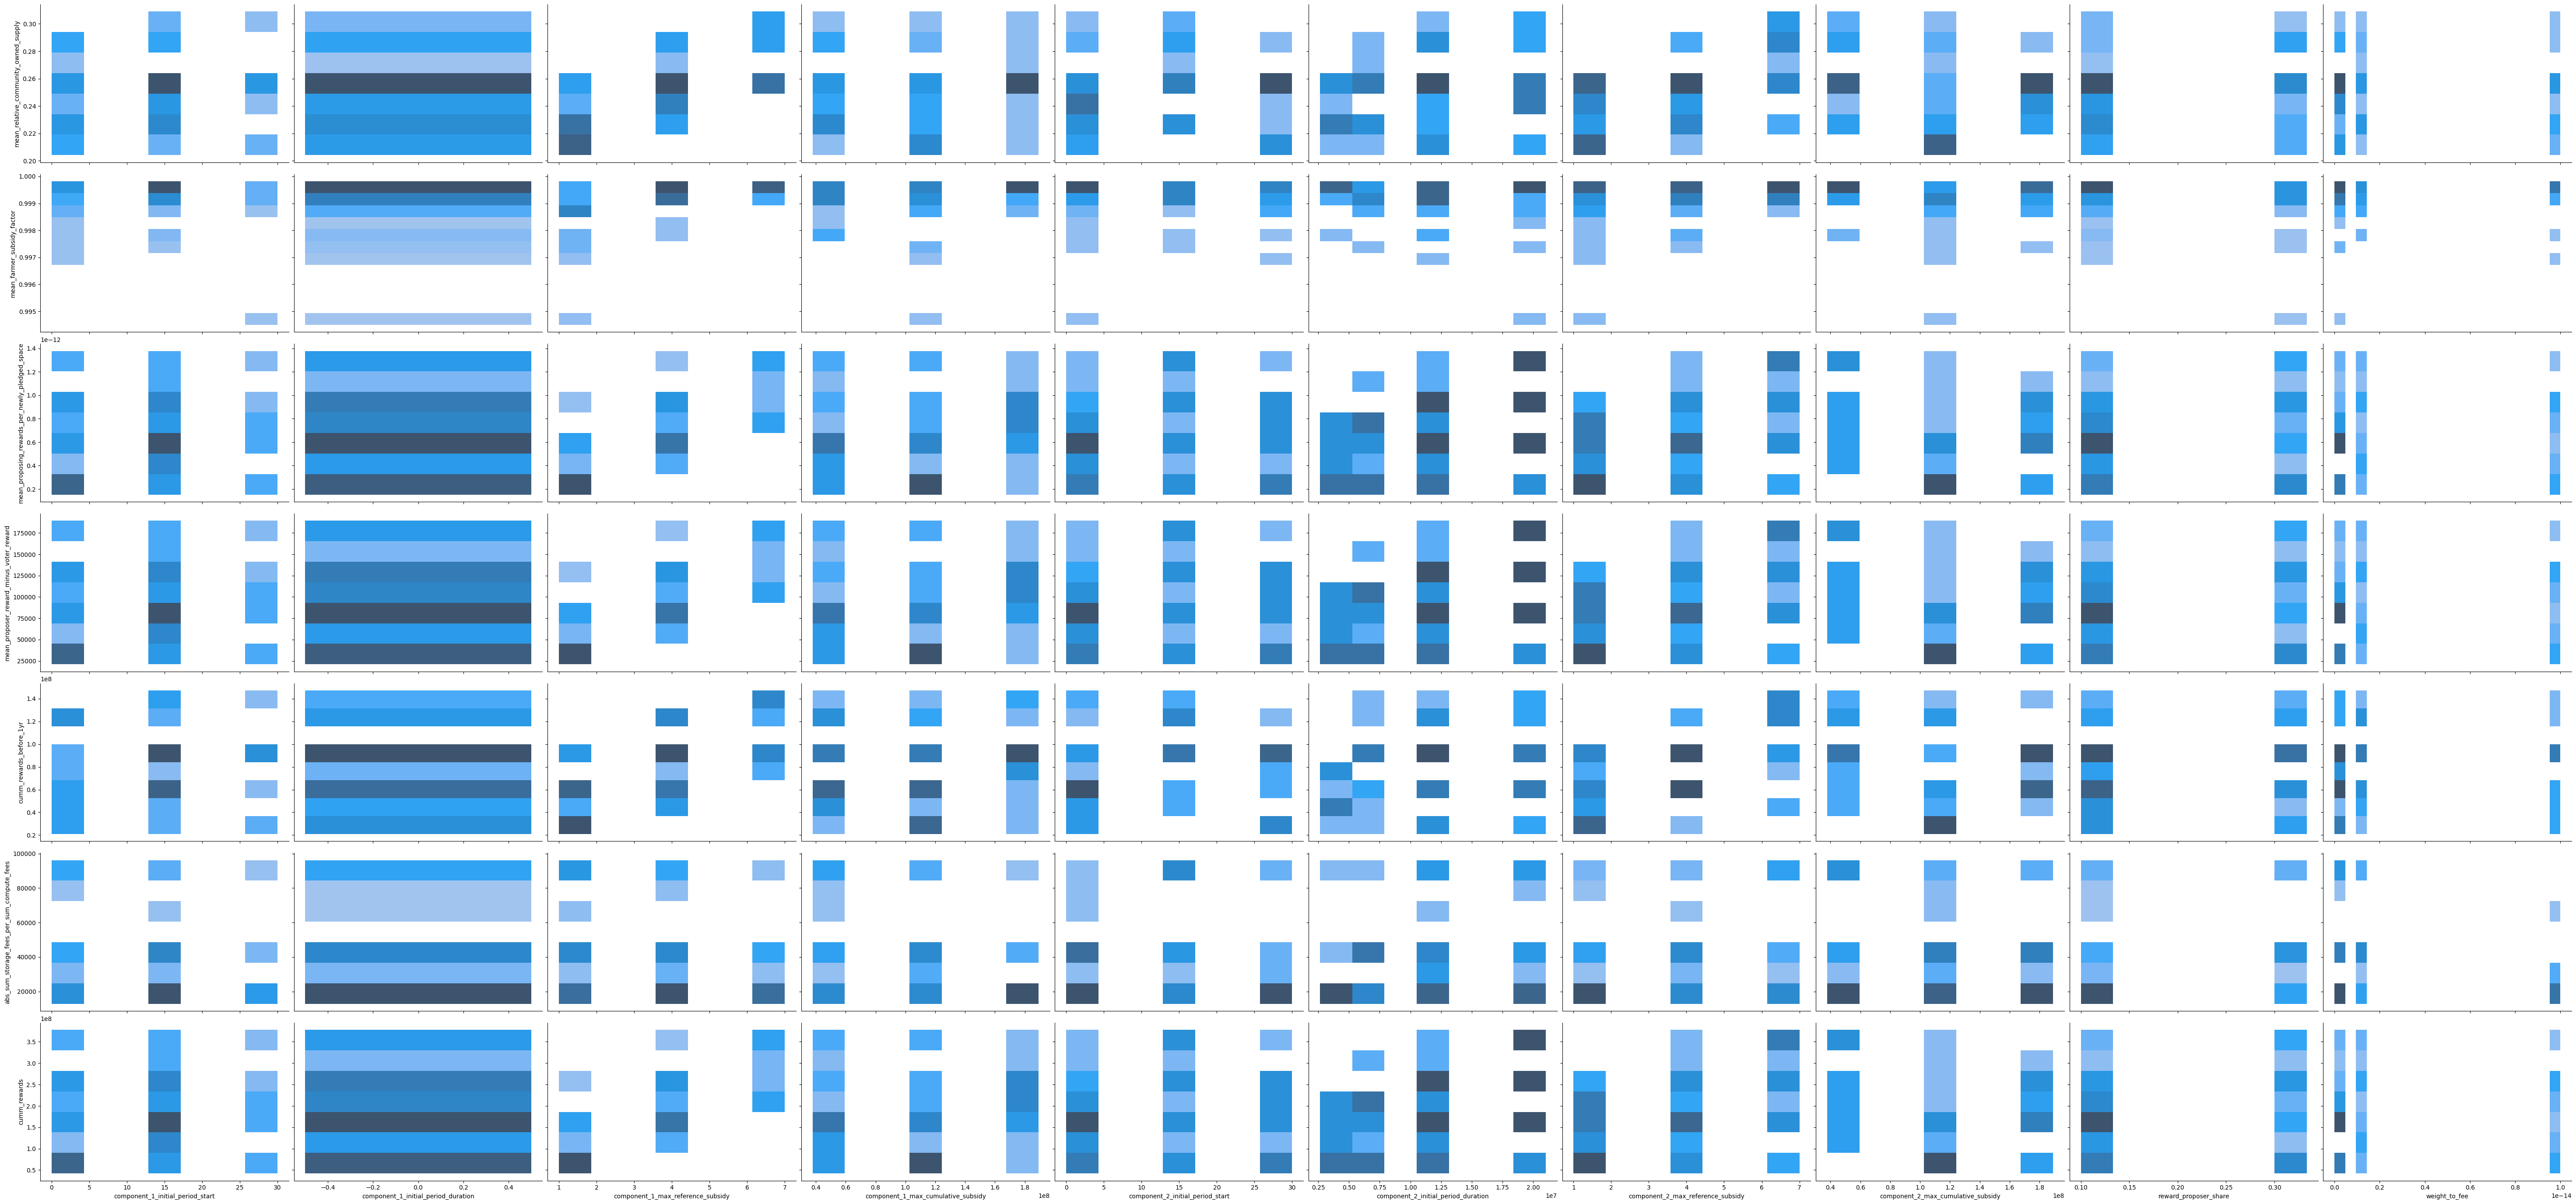

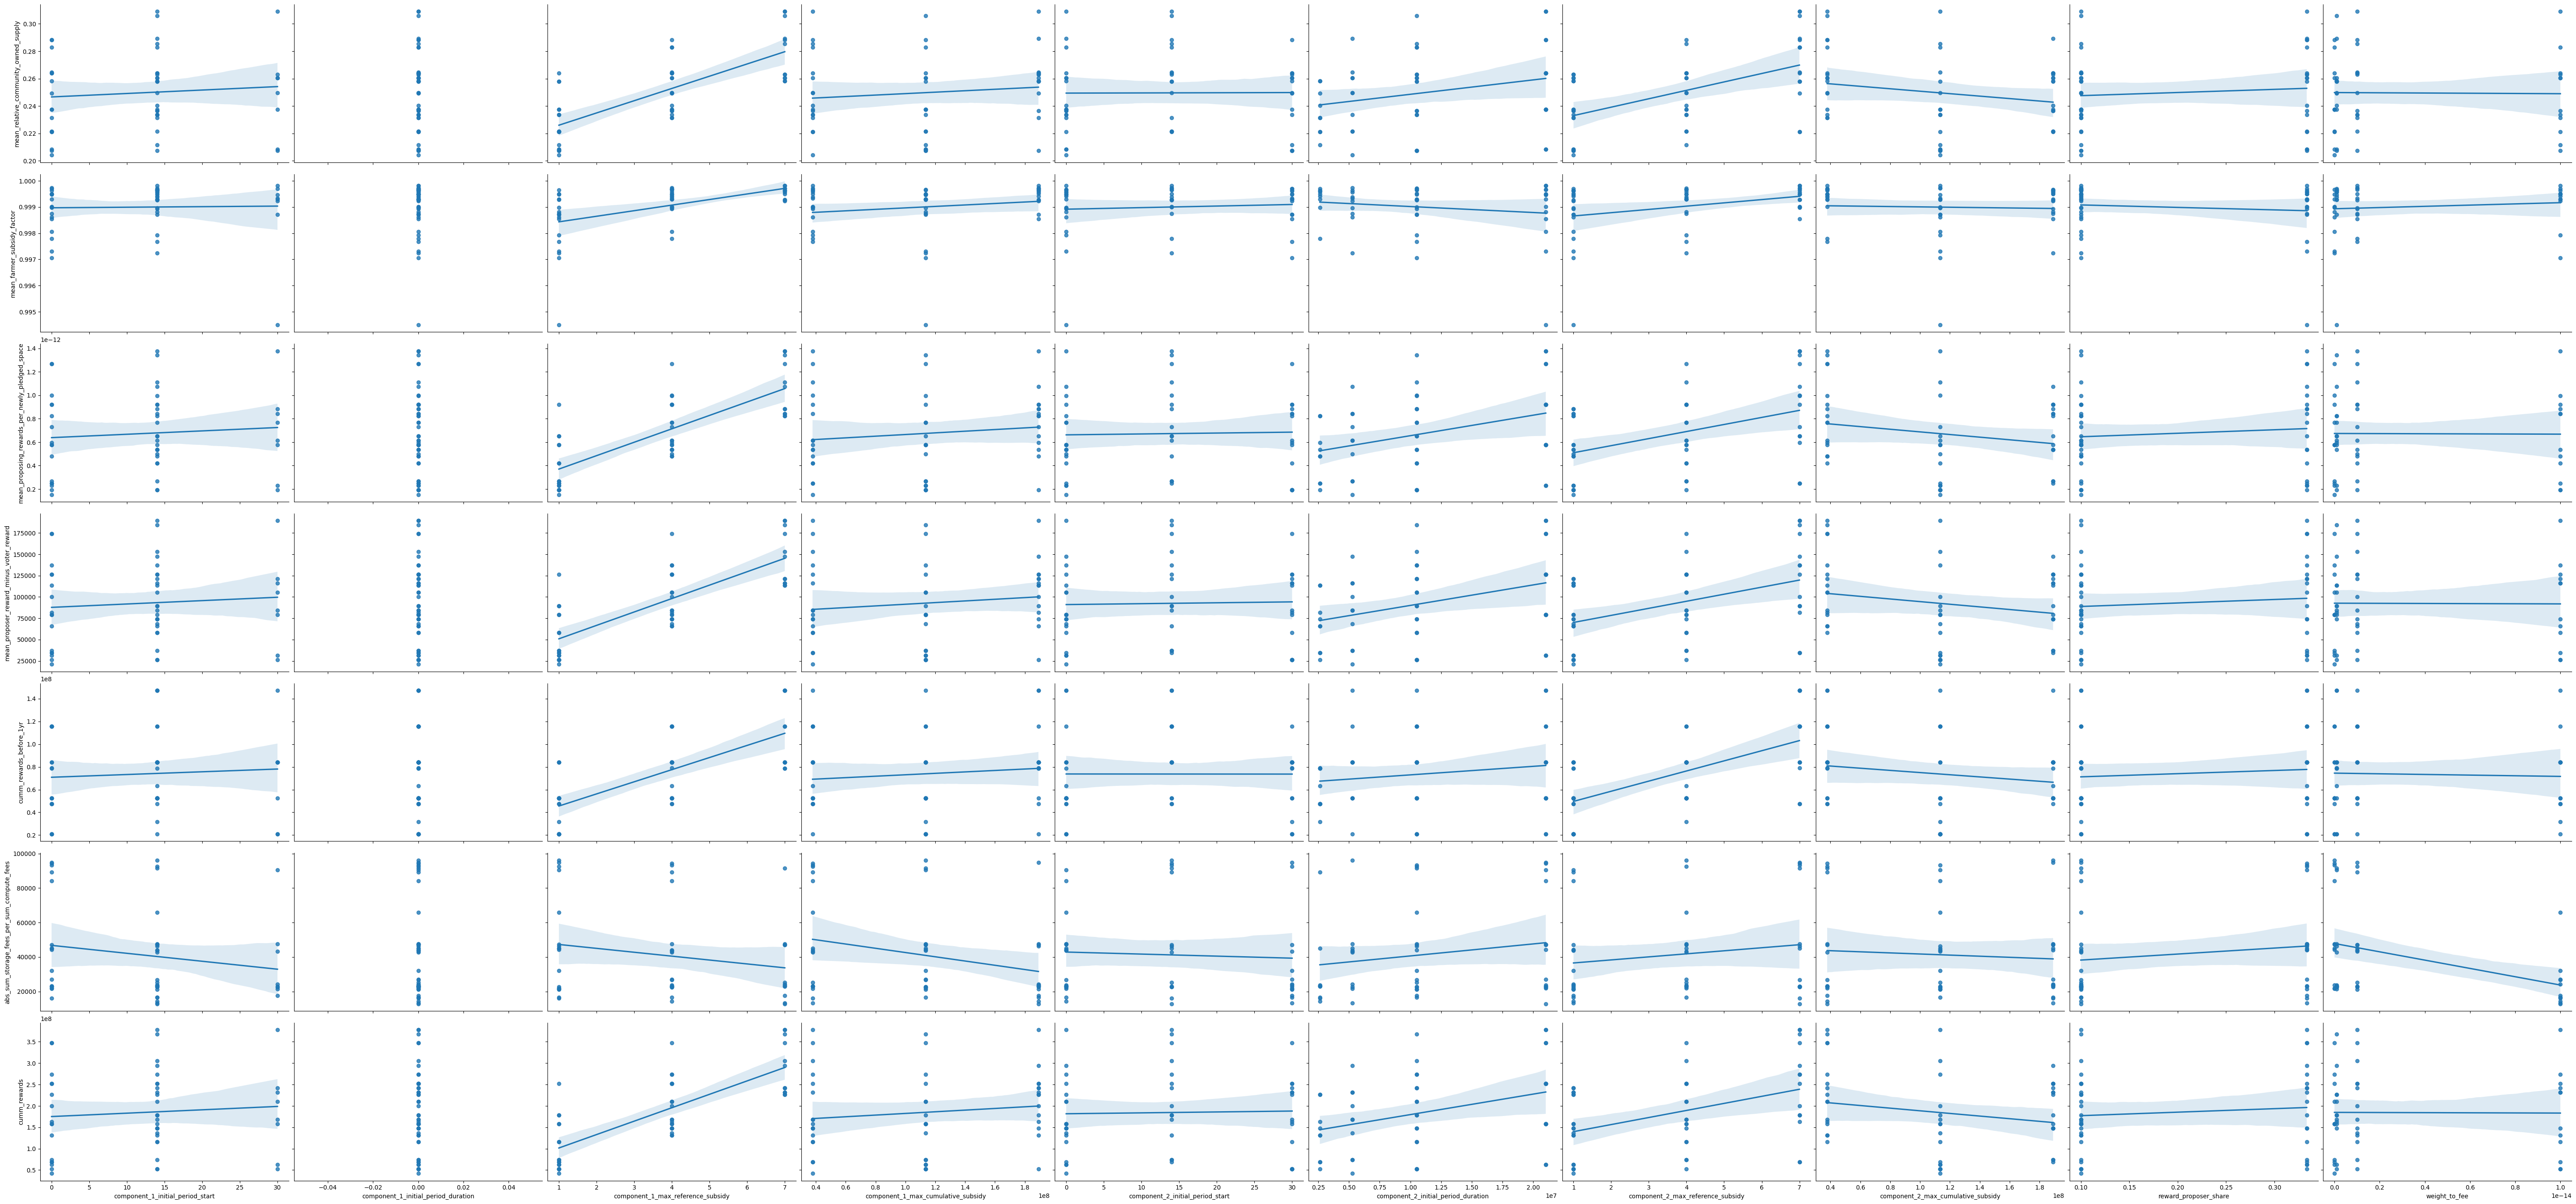

In [24]:
import seaborn as sns

N_params = len(GOVERNANCE_SURFACE_PARAMS)
N_kpis = len(KPI_functions)

N_rows = N_kpis
N_cols = N_params
HEIGHT = 4.0
ASPECT = 1.5

sns.pairplot(data=agg_df, 
             x_vars=GOVERNANCE_SURFACE_PARAMS, 
             y_vars=list(KPI_functions.keys()),
             height=HEIGHT,
             aspect=ASPECT,
             kind='hist')


sns.pairplot(data=agg_df, 
             x_vars=GOVERNANCE_SURFACE_PARAMS, 
             y_vars=list(KPI_functions.keys()),
             height=HEIGHT,
             aspect=ASPECT,
             kind='reg')


In [25]:
agg_df

simulation  subset  run  component_1_max_cumulative_subsidy  \
0            0       0    1                         113460000.0   
1            0       1    2                          37820000.0   
2            0       2    3                          37820000.0   
3            0       3    4                         113460000.0   
4            0       4    5                         113460000.0   
5            0       5    6                         113460000.0   
6            0       6    7                          37820000.0   
7            0       7    8                         113460000.0   
8            0       8    9                          37820000.0   
9            0       9   10                         113460000.0   
10           0      10   11                          37820000.0   
11           0      11   12                         189100000.0   
12           0      12   13                         113460000.0   
13           0      13   14                         189100000.0   
14           0      14   15                         189100000.0   
15           0      15   16                         189100000.0   
16           0      16   17                         189100000.0   
17           0      17   18                         189100000.0   
18           0      18   19                         113460000.0   
19           0      19   20                         189100000.0   
20           0      40    1                          37820000.0   
21           0      41    2                         113460000.0   
22           0      42    3                         113460000.0   
23           0      43    4                         189100000.0   
24           0      44    5                         189100000.0   
25           0      45    6                         113460000.0   
26           0      46    7                         113460000.0   
27           0      47    8                         113460000.0   
28           0      48    9                          37820000.0   
29           0      49   10                          37820000.0   
30           0      20    1                         113460000.0   
31           0      21    2                          37820000.0   
32           0      22    3                          37820000.0   
33           0      23    4                          37820000.0   
34           0      24    5                         189100000.0   
35           0      25    6                          37820000.0   
36           0      26    7                         189100000.0   
37           0      27    8                         113460000.0   
38           0      28    9                         189100000.0   
39           0      29   10                          37820000.0   
40           0      30   11                          37820000.0   
41           0      31   12                          37820000.0   
42           0      32   13                         189100000.0   
43           0      33   14                         113460000.0   
44           0      34   15                         189100000.0   
45           0      35   16                          37820000.0   
46           0      36   17                         113460000.0   
47           0      37   18                         113460000.0   
48           0      38   19                          37820000.0   
49           0      39   20                         189100000.0   

    component_2_initial_period_duration  component_2_max_reference_subsidy  \
0                             2628000.0                                  4   
1                             2628000.0                                  1   
2                             5256000.0                                  1   
3                            21024000.0                                  4   
4                             5256000.0                                  4   
5                            21024000.0                                  1   
6                             2628000.0 

In [26]:
for k in KPI_functions.keys():
    c = agg_df[k].value_counts()
    if len(c) <= 10:
        print(c)

In [27]:
d = agg_df[KPI_functions.keys()].describe().T
d['mean']

mean_relative_community_owned_supply              2.496198e-01
mean_farmer_subsidy_factor                        9.989960e-01
mean_proposing_rewards_per_newly_pledged_space    6.725222e-13
mean_proposer_reward_minus_voter_reward           9.246142e+04
cumm_rewards_before_1yr                           7.369603e+07
abs_sum_storage_fees_per_sum_compute_fees         4.131295e+04
cumm_rewards                                      1.844185e+08
Name: mean, dtype: float64

In [28]:
d['std'] / d['mean']

mean_relative_community_owned_supply              0.112037
mean_farmer_subsidy_factor                        0.000961
mean_proposing_rewards_per_newly_pledged_space    0.510763
mean_proposer_reward_minus_voter_reward           0.510763
cumm_rewards_before_1yr                           0.474607
abs_sum_storage_fees_per_sum_compute_fees         0.647161
cumm_rewards                                      0.510763
dtype: float64